# <center> <ins> Quantitative Trading & Analysis Group Project</ins>

**Group Members:**
* Aditya Bhandare
* VS Chaitanya Madduri
* Rebecca Meier
* Sammir LeSage

**Table of Contents**
1. [Library Imports](#1-library-imports)
2. [Fetching the Data](#2-fetching-the-data)
3. [Data Preparation](#3-data-preparation)
4. [Creating the Benchmark Portfolio](#4-creating-the-benchmark-portfolio)
5. [Backtesting class](#5-backtesting-class)
6. [Trials](#6-trials)
6. [Results](#7-results)

All of the data used in this project was obtained via the class' dropbox folder.

The `Options` class remains intact and should Professor Vilkov run this notebook, it should work without issue.

#### Summary of Findings:

The goal of this project was to improve the performance of a subset of 50 stocks of the SP500 universe using option implied signals. 

We first calculated the benchmark portfolio `df_bm` using a value-weighted, or market-cap weighted, portfolio comprising these 50 stocks from 01/2000 until 12/2021.
The training period was constrained between 01/2000 - 12/2015, with the testing period then being 01/2016 - 12/2021. In addition, several constrains were imposed on the models, such as factor exposure deviation maximum of 0.05, a weight deviation for each asset with a max of 10% of the benchmark weight, and a 1% drawdown constraint relative to the benchmark per month.

Following these constraints, we selected the best performing model during the training period on the basis of Sharpe Ratio and Excess Return with respect to the benchmark, `df_bm`. We found that the `MSR_LGBM` performed the best, with a Sharpe Ratio of **0.62761** and overall returns at **1.79572** during the training period and subsequent Sharpe Ratio of **1.209** and roughly 20% Excess Return with respect to the benchmark portfolio during the testing period. 


To confirm our findings, we ran the testing period using the top three training portfolios based on sharpe ration and sum of returns. Interestingly, we found that `MVP_LGBM` outperformed the `MSR_LGBM` by roughly 9% and 12% for the Sharpe Ratio and sum of returns respectively. 

The following table is a summary of our top three results based on the training Sharpe Ratio.


| Method           | Training SR | Training Returns | Testing SR | Testing Returns|
|------------------|-------------|---------------|----------|--------------|
| MSR_LGBM         | 0.62761     | 1.79572       | 1.119936 |1.143805      |
| MVP              | 0.57757     | 1.641695      | 1.073724 |1.222562      |
| MVP_LGBM         | 0.57906     | 1.56557       | 1.195281 |1.261984      |

### 1. Library Imports

In [1]:
# after we install all the packages, import all of them for the use in today's lecture!
import platform
my_system = platform.uname()
print(f'My PC node: {my_system.node.lower()}')
import time
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats 
from IPython.display import clear_output
# from __future__ import print_function

# database access
import pandas_datareader as web
import quandl as quandl
import wrds as wrds

# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import joblib
import quantstats as qs

from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin, clone
import statsmodels.api as sm
import linearmodels as lm
from scipy.optimize import minimize
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn import metrics
import matplotlib.ticker as mtick

from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool, cpu_count
if cpu_count() > 30:
    CPUUsed = 15
else:
    CPUUsed = cpu_count() - 2

# we can specify some options depending on your computer
class Options:

    if (my_system.node.lower()[0:14] == 'fs-mac-fcy-040'): # GREG'S MACHINE - do not change please
        path = Path('../Data_QT2023')
#         path = Path('/Users/vilkov/Dropbox/SEMINARS/Courses/zFS/MoF-AlgoTradingPython/2022_23SS/Data')
        wrds_name = 'gvfs'
        quandl_key = 'XXX'
    elif (my_system.node.lower() == 'desktop-m5gaseo'):
        path = Path(r'C:\Users\sammi\Frankfurt School\Year II\Spring Semester 2023\Algorithmic Trading\Quant_Trading_with_Python\Data_QT2023')
        wrds_name = 'slesageq'
        pass
    elif (my_system.node.lower() == 'laptop-sfpkifct'):
        path = Path(r'C:\Users\chait\OneDrive - fs-students.de\FSFM_MADS\Semester_4_Q1\Quant_trading\QT2023')
        wrds_name = 'b4241523'
        pass
    
# some file names
class FileNames:
    fn_csv_factors   = Options.path / 'ff_fact.csv'
    fn_excel_factors = Options.path / 'ff_fact.xls'

    fn_crsp     = Options.path / 'crsp.h5'
    key_crsp_daily = 'daily'

    fn_stock_features_labels = Options.path / 'stock_features.h5'
    key_features_crsp = 'crsp'

    fn_stock_features_om = Options.path / 'stock_features_om.h5'
    key_features_om = 'om'

    fn_ff_factors    = Options.path / 'ff_factors.h5'
    key_ff_daily = 'ff_daily'

    fn_sp500comp     = Options.path / 'SP500_Index_Constitutes2020.csv'
    fn_id_link = Options.path / 'daily_permno_secid_cusip_link.csv'
    fn_universe = Options.path / 'permno_selection.csv'

    glb_daily = Options.path / 'glb_daily.csv'

print(f'Paths set; data root is in {Options.path}')
############################
# save the QUANDL API Key:
# quandl.ApiConfig.api_key = Options.quandl_key
# quandl.save_key(quandl.ApiConfig.api_key)
# quandl.read_key()
# print(quandl.ApiConfig.api_key)
############################


# Functions to Load Data
def load_ff_crsp():
    crsp = pd.read_hdf(FileNames.fn_crsp, key = FileNames.key_crsp_daily)
    ff = pd.read_hdf(FileNames.fn_ff_factors, key = FileNames.key_ff_daily)
    return crsp, ff

def load_features(type):
    if type == 'crsp':
        return pd.read_hdf(FileNames.fn_stock_features_labels, key = FileNames.key_features_crsp)
    elif type == 'om':
        return pd.read_hdf(FileNames.fn_stock_features_om, key = FileNames.key_features_om)
    else:
        print('type not supported')

# Functions to Plot Data
def dist_plot(df1):
    sns.kdeplot(df1,
                fill = True,
                label = "Returns", color ="green")
    plt.legend(loc = "upper right")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    pass

def plot_hist(df1, df2, column_name):
    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)

    # plotting the original data(non-normal) and
    # fitted data (normal)
    sns.kdeplot(df1[column_name],
                fill = True,
                #hist = False, kde = True,
                # kde_kws = {'shade': True, 'linewidth': 2},
                label = "Non-Normal", color ="green", ax = ax[0])

    sns.kdeplot(df2[column_name], #hist = False, kde = True,
                fill = True,
                # kde_kws = {'shade': True, 'linewidth': 2},
                label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    pass

def return_stats(results_df,benchmark_df = None, title = None):
    import matplotlib.ticker as mtick
    # provide a different benchmark to compare against
    if benchmark_df is not None:
        results_df["Benchmark"] = benchmark_df.ret_bm-1

    results_df["Benchmark"] = df_bm.ret_bm-1
    sharpe_ratios = results_df.mean()/results_df.std()*np.sqrt(252)
    
    return(pd.concat([results_df.sum().rename("Total Returns"),\
                      (results_df.mean()/results_df.std()*np.sqrt(252)).rename("Sharpe Ratio")],axis=1))


def plot_returns(results_df,benchmark_df = None, title = None):
    import matplotlib.ticker as mtick
    # provide a different benchmark to compare against
    if benchmark_df is not None:
        results_df["Benchmark"] = benchmark_df.ret_bm-1

    results_df["Benchmark"] = df_bm.ret_bm-1
    sharpe_ratios = results_df.mean()/results_df.std()*np.sqrt(252)
    
    # Let's plot the graph
    plt.title(title if title != None else 'Performance of the strategy')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    plt.grid(axis="x")
    plt.legend(list(results_df.columns), loc = 'upper left')
    plt.plot(results_df.dropna().cumsum())

def print_results(df):
    # descriptive stats of performance
    for col in df.columns:
        print('Analysis of the result for configuration: ' + col)
        ret = df[col].dropna()
        ret.cumsum().plot()
        print('Sharpe ratio = ' + str(df[col].mean()/df[col].std()*np.sqrt(252)))
        print('Annual return = ' + str(df[col].sum()))
        print('Average daily return (bps)= ' + str(df[col].mean()* 1e4))
        qs.reports.full(df[col])
        print('****************************************')

# Parsing Functions
def parse_features(df, feature_names, level_winsorize = 0.01):
    df = df.copy().dropna()
    for ft in feature_names:
        # winsorise
        df[ft] = winsorize(df[ft], limits=level_winsorize, nan_policy='omit').data

        # apply cox-box transform
        var_norm, lambda_ = stats.boxcox(df[ft] - df[ft].min() + 0.0001)
        if lambda_ < 5:
            #print(ft + ': optimal lambda = ' + str(lambda_))
            df[ft] = var_norm
        else:
            print(ft + ' procedure failed, skipping cox box transformation')
        #apply z-score scaling
        df[ft] = (df[ft] - df[ft].mean())  / df[ft].abs().max()
    return df

class Winsorize(BaseEstimator, TransformerMixin):
    feature_names = None
    level_winsorize = None
  # add another additional parameter, just for fun, while we are at it
    def __init__(self, feature_names = None, level_winsorize = 0.01):
#         print('\n>>>>>>>init() called.\n')
        self.feature_names = feature_names
        self.level_winsorize = level_winsorize
        self.abs_level_winsorize = {}

    def fit(self, X, y = None):
#         print('>>>>>>>fit() called.')
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        self.feature_names = X_.columns if self.feature_names is None else self.feature_names
        for ft in self.feature_names:
            temp = winsorize(X_.loc[:,ft], limits=self.level_winsorize, nan_policy='omit').data
            self.abs_level_winsorize.update({ft:(np.nanmin(temp), np.nanmax(temp))})
            pass
        # print(f'level:{self.level_winsorize}\n')
        # print(f'abs levels: {self.abs_level_winsorize}\n')
        return self

    def transform(self, X, y = None):
#         print('\n>>>>>>>transform() called.\n')
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for ft in self.feature_names:
            if ft in X_.columns:
                lims = self.abs_level_winsorize[ft]
                tail_left = X_[ft]<=lims[0]
                tail_right = X_[ft]>=lims[1]
                X_.loc[tail_left, ft] = lims[0]
                X_.loc[tail_right, ft] = lims[1]
            else:
                print(f'Warning: {ft} not in the list of variables/ skipping')
            pass
        return X_

My PC node: desktop-m5gaseo
Paths set; data root is in C:\Users\sammi\Frankfurt School\Year II\Spring Semester 2023\Algorithmic Trading\Quant_Trading_with_Python\Data_QT2023


In [2]:
pd.read_hdf(Options.path/"stock_features_om.h5", key = "om")

secid    iv_atm  put_skew  call_skew      skew
permno  date                                                         
10078.0 1999-01-04  110611.0  0.486494  0.039651  -0.001333 -0.040984
        1999-01-05  110611.0  0.480915  0.041183   0.006064 -0.035119
        1999-01-06  110611.0  0.499534  0.040747  -0.000403 -0.041150
        1999-01-07  110611.0  0.513503  0.031808  -0.004324 -0.036132
        1999-01-08  110611.0  0.504433  0.039444   0.005468 -0.033976
...                      ...       ...       ...        ...       ...
93436.0 2021-12-27  143439.0  0.638115  0.037207   0.051445  0.014238
        2021-12-28  143439.0  0.629923  0.039669   0.052126  0.012457
        2021-12-29  143439.0  0.622361  0.044293   0.045233  0.000940
        2021-12-30  143439.0  0.612872  0.046054   0.030060 -0.015994
        2021-12-31  143439.0  0.610270  0.040216   0.038864 -0.001352

[4007661 rows x 5 columns]

### 2. Fetching the data:

In [3]:
# define functions to load data
def load_ff_crsp():
    crsp = pd.read_hdf(FileNames.fn_crsp, key = FileNames.key_crsp_daily)
    ff = pd.read_hdf(FileNames.fn_ff_factors, key = FileNames.key_ff_daily)
    return crsp, ff

def load_features(type):
    if type == 'crsp':
        return pd.read_hdf(FileNames.fn_stock_features_labels, key = FileNames.key_features_crsp)
    elif type == 'om':
        return pd.read_hdf(FileNames.fn_stock_features_om, key = FileNames.key_features_om)
    else:
        print('type not supported')

def plot_hist(df1, df2, column_name):
    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)

    # plotting the original data(non-normal) and
    # fitted data (normal)
    sns.kdeplot(df1[column_name],
                fill = True,
                #hist = False, kde = True,
                # kde_kws = {'shade': True, 'linewidth': 2},
                label = "Non-Normal", color ="green", ax = ax[0])

    sns.kdeplot(df2[column_name], #hist = False, kde = True,
                fill = True,
                # kde_kws = {'shade': True, 'linewidth': 2},
                label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    pass

def parse_features(df, feature_names, level_winsorize = 0.01):
    df = df.copy().dropna()
    for ft in feature_names:
        # winsorise
        df[ft] = winsorize(df[ft], limits=level_winsorize, nan_policy='omit').data

        # apply cox-box transform
        var_norm, lambda_ = stats.boxcox(df[ft] - df[ft].min() + 0.0001)
        if lambda_ < 5:
            #print(ft + ': optimal lambda = ' + str(lambda_))
            df[ft] = var_norm
        else:
            print(ft + ' procedure failed, skipping cox box transformation')
        #apply z-score scaling
        df[ft] = (df[ft] - df[ft].mean())  / df[ft].abs().max()
    return df

class Winsorize(BaseEstimator, TransformerMixin):
    feature_names = None
    level_winsorize = None
  # add another additional parameter, just for fun, while we are at it
    def __init__(self, feature_names = None, level_winsorize = 0.01):
#         print('\n>>>>>>>init() called.\n')
        self.feature_names = feature_names
        self.level_winsorize = level_winsorize
        self.abs_level_winsorize = {}

    def fit(self, X, y = None):
#         print('>>>>>>>fit() called.')
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        self.feature_names = X_.columns if self.feature_names is None else self.feature_names
        for ft in self.feature_names:
            temp = winsorize(X_.loc[:,ft], limits=self.level_winsorize, nan_policy='omit').data
            self.abs_level_winsorize.update({ft:(np.nanmin(temp), np.nanmax(temp))})
            pass
        # print(f'level:{self.level_winsorize}\n')
        # print(f'abs levels: {self.abs_level_winsorize}\n')
        return self

    def transform(self, X, y = None):
#         print('\n>>>>>>>transform() called.\n')
        X_ = X.copy() # creating a copy to avoid changes to original dataset
        for ft in self.feature_names:
            if ft in X_.columns:
                lims = self.abs_level_winsorize[ft]
                tail_left = X_[ft]<=lims[0]
                tail_right = X_[ft]>=lims[1]
                X_.loc[tail_left, ft] = lims[0]
                X_.loc[tail_right, ft] = lims[1]
            else:
                print(f'Warning: {ft} not in the list of variables/ skipping')
            pass
        return X_
    
def prepare_save_rets(load_factors = True, factors_from = 1999,
                     load_crsp_data = True, crsp_from = 1999,
                     restrict_universe = True):
    import time

    UNIVERSE_PERMNO = ''
    UNIVERSE_SECID = ''
    if restrict_universe:
        # read the sp500 composition and make the string from PERMNO for SQL
        comp = pd.read_csv(FileNames.fn_sp500comp)
        comp['start']  = pd.to_datetime(comp['start'])
        comp['ending'] = pd.to_datetime(comp['ending'])
        comp = comp.loc[comp.ending>'1998',:]
        universe = list(pd.read_csv(FileNames.fn_universe).permno)
        universe_permno = tuple(universe)
        UNIVERSE_PERMNO = f'AND a.permno in {universe_permno}'

        id_link = pd.read_csv(FileNames.fn_id_link)
        universe_secid = tuple(id_link[id_link.date>=str(1999)].secid)
        UNIVERSE_SECID = f'AND a.secid in {universe_secid}'
        pass

    if load_factors:
        startdt = datetime.datetime(factors_from,1,1)

        d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt)
        d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt)
        d3 = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench',start=startdt)

        ff = d1[0]/100
        ff = ff.join(d2[0]/100, how = 'left')
        ff5 = d3[0]/100
        ff = ff.join(ff5.loc[:,['RMW','CMA']], how = 'left')

        ff.columns = [z.lower().strip() for z in ff.columns]
        ff.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

        ff = ff.loc[:,['mktrf', 'smb', 'hml', 'mom', 'rmw', 'cma','rf']]
        # ff.to_hdf(FileNames.fn_ff_factors, key = FileNames.key_ff_daily, mode = 'w')

        # print(f'Saved FF factors')
        pass

    if load_crsp_data:

        # get the data!
        db = wrds.Connection(wrds_username=Options.wrds_name)
        
        start = time.time()
        
        data_crsp = pd.DataFrame()
        for YR in range(crsp_from,2022):
            
            sql_wrds = f"""
            select distinct a.date, a.permno, a.cusip, a.ret, abs(a.prc) as prc, a.shrout, abs(a.prc)*a.shrout/1000 as mktcap, a.vol
            from crsp.dsf as a
            where
            EXTRACT(YEAR FROM a.date) = {YR}
            {UNIVERSE_PERMNO}
            ORDER BY a.permno, a.date
            """
            data_crsp = pd.concat([data_crsp,db.raw_sql(sql_wrds)], axis = 0)
            print(f'finished downloading CRSP {YR} in {(time.time()-start)/60:.2f} minutes')
            pass
        
        data_crsp['date'] = pd.to_datetime(data_crsp['date'])
        db.close()

        data_crsp = data_crsp.sort_values(by = ['permno','date'])
        data_crsp['mktcap'] = data_crsp.groupby(['permno'])['mktcap'].shift(1)
        data_crsp['vw'] = data_crsp['mktcap']/data_crsp.groupby(['date'])['mktcap'].transform('sum')

        # data_crsp.to_hdf(FileNames.fn_crsp, key = FileNames.key_crsp_daily, mode = 'w')
        # print(f'Saved CRSP data')
        pass
    return ff, data_crsp
 
def load_ff_crsp():
    crsp = pd.read_hdf(FileNames.fn_crsp, key = FileNames.key_crsp_daily)
    ff = pd.read_hdf(FileNames.fn_ff_factors, key = FileNames.key_ff_daily)
    return crsp, ff   

def load_features():
    features_crsp = pd.read_hdf(FileNames.fn_stock_features_labels, key = FileNames.key_features_crsp)
    return features_crsp  

def get_beta_bypermno(df, permno=None, window=252, min_n=int(252/2), factor_model='ff4'):

    if (permno is not None) and (permno in df.columns): 
        df = df.rename(columns={permno: 'ret'})
    else:
        print(f'permno {permno} not in the data')        
    if factor_model == 'capm':
        formula = f'ret ~ 1 +  mktrf'
    elif factor_model == 'ff3':
        formula = f'ret ~ 1 +  mktrf + smb + hml'
    elif factor_model == 'ff4':
        formula = f'ret ~ 1 +  mktrf + smb + hml + mom'
    elif factor_model == 'ff5':
        formula = f'ret ~ 1 +  mktrf + smb + hml + rmw + cma'
    else:
        formula = f'ret ~ 1'
        pass

    try:
        rres = RollingOLS.from_formula(formula, 
                                       data=df, 
                                       window=window, 
                                       min_nobs=min_n,
                                       missing='drop').fit(params_only=False)
        temp_beta = rres.params.iloc[:,1:]
        temp_beta.columns = [f'beta_{z}' for z in temp_beta.columns]
        temp_beta = temp_beta.join((rres.mse_resid.to_frame(f'idvar_{factor_model}')*252))
        temp_beta['permno'] = permno
        temp_beta = temp_beta.dropna(axis=1, how ='all')
        return temp_beta.reset_index()
    except:
        pass
    pass

def compute_features_labels(data, 
                            ff,
                            factor_model = 'ff4',
                            SaveResults = True):
    
    res_dict = {}
    
    cols2use = ['permno','date','ret','mktcap']
    data0 = data.reset_index()[cols2use].copy()
    data0.sort_values(by = ['permno','date'], inplace = True)

    # let us compute 1-day return by groups
    data0['fret1d'] = data0.groupby(by=['permno'])['ret'].shift(-1)

    # let us compute 5-day forward return
    fn_5dret = lambda x: np.exp(x.rolling(window=5, min_periods=3).sum())-1

    data0['lret'] = np.log(1+data0['ret'])
    data0['fret5d'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_5dret).shift(-5).values
    
    # forward returns 
    print('Computed forward returns')
    frets = {'frets':['fret1d','fret5d']}
    res_dict.update(frets)

    # momentum/ reversal can be defined in a number of ways, 
    #e.g. momentum = total return from months - 13 to -1:
    fn_mom12m = lambda x: np.exp(x.rolling(window=252, min_periods=63).sum())-1
    #e.g. momentum = total return from months - 7 to -1:
    fn_mom6m = lambda x: np.exp(x.rolling(window=126, min_periods=31).sum())-1
    #e.g. reversal = total return for past month:
    fn_rev = lambda x: np.exp(x.rolling(window=21, min_periods=15).sum())-1


    data0['mom12m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_mom12m).shift(22).values

    data0['mom6m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_mom6m).shift(22).values

    data0['rev1m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_rev).values
    
    data0.drop(columns = ['lret'], inplace = True)
    # mom_rev 
    print('Computed momentum/ reversal')
    momrev = {'momrev':['mom12m','mom6m','rev1m']}
    res_dict.update(momrev)
    
    
    # factor betas 
    # create a slimmer copy for work 
    cols2use = ['permno','date','ret']
    data1 = data0[cols2use].copy().set_index(['date','permno']).sort_index()

    df_ret = data1['ret'].unstack()
    universe = list(df_ret.columns)

    # subtract risk-free rate from returns to get excess returns 
    idx = df_ret.index
    df_ret = df_ret.subtract(ff.loc[idx,'rf'], axis=0)

    # merge to include factors 
    factors = ['mktrf','smb','hml','mom','rmw','cma']
    df_ret = df_ret.merge(ff.loc[idx,factors], on = 'date')
    
    with Parallel(n_jobs=CPUUsed) as parallel:
        res = parallel(delayed(get_beta_bypermno)(df_ret[[permno, *factors]],
                                          permno,
                                          window = 252,
                                          min_n = 126,
                                          factor_model = factor_model) for permno in universe)
        pass
    
    temp = pd.concat(res)
    temp = temp.set_index(['permno','date']).sort_index().dropna()
    
    ##
    print('Computed factor betas')
    facts = {'fmodels':list(temp.columns)}
    res_dict.update(facts)
    
    data0 = data0.set_index(['permno','date'])
    
    data0 = data0.merge(temp, on = ['permno','date'])
    
    if SaveResults:
        # data0.to_hdf(FileNames.fn_stock_features_labels, key= FileNames.key_features_crsp, mode = 'w')
        pass

    return data0, res_dict

Loading the data and the 50 permno universe:

In [4]:
# Defining Universe:
universe = list(pd.read_csv(FileNames.fn_universe).permno)

# Loading the CRSP data for the 50 selected stocks from 1999 onwards:
ff, crsp = prepare_save_rets(load_factors = True, factors_from = 1999,
                     load_crsp_data = True, crsp_from = 1999,
                     restrict_universe = True)



# # computing the beta by permno for each file
res, res_dict = compute_features_labels(data = crsp, 
                            ff = ff,
                            factor_model = 'ff4',
                            SaveResults = True)

# OptionMetrics:
# features_om = pd.read_hdf(FileNames.fn_stock_features_om, key = FileNames.key_features_om)

db = wrds.Connection(wrds_username=Options.wrds_name)
db.create_pgpass_file() # -> Automates the login so that we onl have to do it once.

# Importing the Options data:
id_link = pd.read_csv(FileNames.fn_id_link)
id_link['date'] = pd.to_datetime(id_link['date'])

# Inspecting the data
print(id_link.head())
stonks = id_link.permno.isin(universe)
secids = id_link.loc[stonks, 'secid'].unique()
print(f'There have been {secids.shape[0]} stocks traded in the SP500 since 01 January 1999')

# Light data cleaning
universe_secid = tuple(id_link.loc[stonks, 'secid'].dropna().unique())
UNIVERSE_SECID = f'AND secid in {universe_secid}'

data_om = pd.DataFrame()

for YR in range(1999, 2022):
    sql_aiv = f'''
    SELECT a.date, a.secid,
    a.iv_atm as iv_atm,
    b.aiv_otmput AS put_skew,
    c.aiv_otmcall AS call_skew,
    b.aiv_otmput-a.iv_atmcall AS skew FROM

    (SELECT date, secid, AVG(impl_volatility) as iv_atmcall
    FROM optionm.vsurfd{YR}
    WHERE days=30 AND delta=50
    {UNIVERSE_SECID}
    GROUP BY date, secid) as a,

    (SELECT date, secid, AVG(impl_volatility) as aiv_otmput
    FROM optionm.vsurfd{YR}
    WHERE days=30 AND delta=-10
    {UNIVERSE_SECID}
    GROUP BY date, secid) as b,

    (SELECT date, secid, AVG(impl_volatility) as aiv_otmcall
    FROM optionm.vsurfd{YR}
    WHERE days = 30 AND delta =10
    {UNIVERSE_SECID}
    GROUP BY date, secid) AS c

    WHERE a.date = b.date AND a.secid = b.secid
    AND a.date = c.date AND a.secid = c.secid

    '''

    # Executing Query and iterating through the date range:
    data_om = pd.concat([data_om,db.raw_sql(sql_aiv)], axis = 0)

    # Additional query skew calculations if needed.
    # b.aiv_otmput - a.iv_atmcall AS put_skew,
    # c.aiv_otmcall-a.iv_atm AS call_skew, 

# saving the data:
data_om.to_hdf(Options.path/'Options_data', key='df', mode='w')

# # reading the data file:
# data_om = pd.read_hdf('Options_data', key='df', mode='r')

data_om.loc[:,'date'] = pd.to_datetime(data_om.loc[:, 'date'])
data_om = data_om.merge(id_link[['date', 'permno', 'secid']], how='left', on=['date', 'secid'])
data_om.head()

# Merging the data:
res_ = res.copy().reset_index()

df = pd.merge(res_, data_om, how="inner")
df = df.set_index(['permno', 'date']).sort_index()

# saving the joined, processed data:
df.to_hdf(Options.path/'merged_data.h5', key='df', mode='w')

Loading library list...
Done
finished downloading CRSP 1999 in 0.04 minutes
finished downloading CRSP 2000 in 0.04 minutes
finished downloading CRSP 2001 in 0.05 minutes
finished downloading CRSP 2002 in 0.07 minutes
finished downloading CRSP 2003 in 0.08 minutes
finished downloading CRSP 2004 in 0.09 minutes
finished downloading CRSP 2005 in 0.10 minutes
finished downloading CRSP 2006 in 0.11 minutes
finished downloading CRSP 2007 in 0.12 minutes
finished downloading CRSP 2008 in 0.13 minutes
finished downloading CRSP 2009 in 0.14 minutes
finished downloading CRSP 2010 in 0.15 minutes
finished downloading CRSP 2011 in 0.16 minutes
finished downloading CRSP 2012 in 0.17 minutes
finished downloading CRSP 2013 in 0.19 minutes
finished downloading CRSP 2014 in 0.20 minutes
finished downloading CRSP 2015 in 0.21 minutes
finished downloading CRSP 2016 in 0.22 minutes
finished downloading CRSP 2017 in 0.23 minutes
finished downloading CRSP 2018 in 0.24 minutes
finished downloading CRSP 2019 

C:\Users\sammi\AppData\Local\Temp\ipykernel_13388\979930170.py:78: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->date,key->block0_values] [items->Index(['date'], dtype='object')]

  data_om.to_hdf(Options.path/'Options_data', key='df', mode='w')
C:\Users\sammi\AppData\Local\Temp\ipykernel_13388\979930170.py:83: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_om.loc[:,'date'] = pd.to_datetime(data_om.loc[:, 'date'])


### 3. Data Preparation:

In [5]:
# let me for simplicity drop NAN values --
print(df.shape,df.index.get_level_values('permno').unique().shape)
df.dropna(inplace = True)
print(df.shape,df.index.get_level_values('permno').unique().shape)

(276841, 17) (50,)
(276665, 17) (50,)


Use if merged_df.h5 file is already created:

In [6]:
# Importing data from existing file
# df = pd.read_hdf("./Fetched_data/merged_data.h5", key = "df")


# # Merging with the GLB file:

# # loading the dataframe:
# glb = pd.read_csv(Options.path/'glb_daily.csv')

# # light cleaning
# glb.rename({'id':'permno'}, axis=1, inplace=True)
# glb['date'] = pd.to_datetime(glb['date'])

# # Resetting the index:
# glb = glb.reset_index().set_index(['permno', 'date'])

# # Dropping old index
# glb.drop('index', axis=1, inplace=True)

# # final merge:
# df = df.merge(glb, how='inner', on=['permno', 'date'])
# df

In [6]:
# Ensuring that only the permnos in the 50 permno universe are taken:
df = df[df.index.get_level_values('permno').isin(universe)]

Per the instructions, we are only interested in the data until 31.12.2021, so:

In [7]:
# Capping the data between 31.12.1999 - 31.12.2021:
df = df.reset_index()
df = df[df.date < "2022"]
df = df.set_index(['permno', 'date']).sort_index()
df

ret        mktcap    fret1d    fret5d    mom12m  \
permno  date                                                               
10874.0 1999-12-31 -0.011111   2066.107500 -0.014045 -0.039326 -0.099618   
        2000-01-03 -0.014045   2043.150750 -0.045584 -0.022792 -0.109937   
        2000-01-04 -0.045584   2014.454812  0.005970  0.023881 -0.107357   
        2000-01-05  0.005970   1922.627812  0.008902  0.014837 -0.112517   
        2000-01-06  0.008902   1934.106188  0.005882  0.014706 -0.115097   
...                      ...           ...       ...       ...       ...   
88664.0 2021-12-17 -0.005209  12224.169552 -0.007611  0.007976  0.002516   
        2021-12-20 -0.007611  12160.494247  0.012455  0.026934 -0.020797   
        2021-12-21  0.012455  12067.942997  0.004908  0.017089 -0.032678   
        2021-12-22  0.004908  12218.246136 -0.002412  0.011397 -0.040678   
        2021-12-23 -0.002412  12278.219166  0.000725  0.009430 -0.032781   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  \
permno  date                                                             
10874.0 1999-12-31 -0.057281  0.031884    0.998254  0.764682  0.404181   
        2000-01-03 -0.080380  0.014451    1.032156  0.784538  0.414427   
        2000-01-04 -0.099108 -0.026163    1.079493  0.830231  0.437168   
        2000-01-05 -0.115711 -0.017493    1.113169  0.829421  0.402571   
        2000-01-06 -0.099960  0.017964    1.113622  0.839856  0.356142   
...                      ...       ...         ...       ...       ...   
88664.0 2021-12-17  0.032204  0.071109    0.982004 -0.309253  0.102690   
        2021-12-20 -0.004606  0.076962    0.978751 -0.308384  0.101997   
        2021-12-21 -0.018372  0.080340    0.969122 -0.310643  0.102376   
        2021-12-22 -0.017467  0.085856    0.962951 -0.305666  0.098053   
        2021-12-23 -0.015148  0.084227    0.962193 -0.305499  0.100190   

                    beta_mom  idvar_ff4     secid    iv_atm  put_skew  \
permno  date                                                            
10874.0 1999-12-31 -0.673465   0.149743  102386.0  0.391729  0.390299   
        2000-01-03 -0.746982   0.146484  102386.0  0.377306  0.383622   
        2000-01-04 -0.727018   0.147118  102386.0  0.381634  0.386107   
        2000-01-05 -0.801960   0.146055  102386.0  0.384885  0.376034   
        2000-01-06 -0.855652   0.144450  102386.0  0.386594  0.373572   
...                      ...        ...       ...       ...       ...   
88664.0 2021-12-17 -0.429145   0.037244  105683.0  0.217621  0.439553   
        2021-12-20 -0.429191   0.037260  105683.0  0.256910  0.349994   
        2021-12-21 -0.419554   0.037096  105683.0  0.259400  0.443218   
        2021-12-22 -0.413923   0.037020  105683.0  0.245635  0.346727   
        2021-12-23 -0.415112   0.037058  105683.0  0.263290  0.343746   

                    call_skew      skew  
permno  date                             
10874.0 1999-12-31   0.393479 -0.001430  
        2000-01-03   0.410990  0.006316  
        2000-01-04   0.390472  0.004473  
        2000-01-05   0.371259 -0.008851  
        2000-01-06   0.394718 -0.013022  
...                       ...       ...  
88664.0 2021-12-17   0.267900  0.221932  
        2021-12-20   0.252879  0.093084  
        2021-12-21   0.346066  0.183818  
        2021-12-22   0.282042  0.101092  
        2021-12-23   0.283856  0.080456  

[276665 rows x 17 columns]

In [8]:
len(df.index.get_level_values("permno").unique())

50

In [10]:
# Importing the new option data provided
glb_daily = pd.read_csv(FileNames.glb_daily)
glb_daily.rename(columns={"id":"permno"}, inplace=True)
glb_daily.date = pd.to_datetime(glb_daily.date)
glb_daily = glb_daily.set_index(["permno","date"]).sort_index()

glb_daily.head()

glb2_D30  glb3_D30  glb2_D91  glb3_D91  glb2_D182  \
permno  date                                                            
10078.0 1996-01-04  0.068033  0.067927  0.057906  0.057766   0.050746   
        1996-01-05  0.068033  0.067927  0.057906  0.057766   0.050746   
        1996-01-08  0.068033  0.067927  0.057906  0.057766   0.050746   
        1996-01-09  0.068033  0.067927  0.057906  0.057766   0.050746   
        1996-01-10  0.068033  0.067927  0.057906  0.057766   0.050746   

                    glb3_D182  glb2_D273  glb3_D273  glb2_D365  glb3_D365  
permno  date                                                               
10078.0 1996-01-04   0.050633   0.050788   0.050661   0.050624   0.050577  
        1996-01-05   0.050633   0.050788   0.050661   0.050624   0.050577  
        1996-01-08   0.050633   0.050788   0.050661   0.050624   0.050577  
        1996-01-09   0.050633   0.050788   0.050661   0.050624   0.050577  
        1996-01-10   0.050633   0.050788   0.050661   0.050624   0.050577

In [11]:
# Joining df with the glb dataframe
df = df.join(glb_daily)
# print(df.columns)
df.dropna(inplace = True)
print(df.shape,df.index.get_level_values('permno').unique().shape)
df.head()

(201077, 27) (50,)


ret       mktcap    fret1d    fret5d    mom12m  \
permno  date                                                              
10874.0 2004-04-05  0.013269  3883.782171 -0.002619 -0.021905  1.199157   
        2004-04-06 -0.002619  3935.316000 -0.003581 -0.006923  1.219418   
        2004-04-07 -0.003581  3925.009163 -0.014854  0.004791  1.263542   
        2004-04-08 -0.014854  3910.954677  0.017510  0.034776  1.352782   
        2004-04-12  0.017510  3852.861660 -0.018164  0.014579  1.390541   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  ...  \
permno  date                                                            ...   
10874.0 2004-04-05  0.442925  0.067887    0.929207  0.021911  0.135846  ...   
        2004-04-06  0.429375  0.039712    0.927334  0.000899  0.078156  ...   
        2004-04-07  0.462696  0.010654    0.924014 -0.019639  0.076406  ...   
        2004-04-08  0.483999 -0.000486    0.921625 -0.003121  0.085215  ...   
        2004-04-12  0.491957  0.064090    0.924204 -0.002850  0.064028  ...   

                    glb2_D30  glb3_D30  glb2_D91  glb3_D91  glb2_D182  \
permno  date                                                            
10874.0 2004-04-05  0.035464  0.035481  0.050650  0.050673   0.035364   
        2004-04-06  0.038330  0.038348  0.052306  0.052330   0.036417   
        2004-04-07  0.039063  0.039082  0.052088  0.052112   0.038584   
        2004-04-08  0.043796  0.043817  0.054256  0.054281   0.039548   
        2004-04-12  0.041880  0.041900  0.050045  0.050068   0.037018   

                    glb3_D182  glb2_D273  glb3_D273  glb2_D365  glb3_D365  
permno  date                                                               
10874.0 2004-04-05   0.035381   0.030965   0.030980   0.030565   0.030580  
        2004-04-06   0.036435   0.032837   0.032853   0.032469   0.032485  
        2004-04-07   0.038603   0.036476   0.036494   0.036289   0.036306  
        2004-04-08   0.039567   0.037078   0.037096   0.036818   0.036835  
        2004-04-12   0.037035   0.036137   0.036154   0.036258   0.036275  

[5 rows x 27 columns]

In [14]:
df

ret        mktcap    fret1d    fret5d    mom12m  \
permno  date                                                               
10874.0 2004-04-05  0.013269   3883.782171 -0.002619 -0.021905  1.199157   
        2004-04-06 -0.002619   3935.316000 -0.003581 -0.006923  1.219418   
        2004-04-07 -0.003581   3925.009163 -0.014854  0.004791  1.263542   
        2004-04-08 -0.014854   3910.954677  0.017510  0.034776  1.352782   
        2004-04-12  0.017510   3852.861660 -0.018164  0.014579  1.390541   
...                      ...           ...       ...       ...       ...   
88664.0 2021-11-12 -0.009233  11788.068107 -0.004691 -0.028718  0.029657   
        2021-11-15 -0.004691  11679.227747  0.004076 -0.024331  0.055661   
        2021-11-16  0.004076  11624.437000 -0.024359 -0.029180  0.059646   
        2021-11-17 -0.024359  11671.823195 -0.013004 -0.006437  0.066143   
        2021-11-18 -0.013004  11387.506026  0.009289 -0.004348  0.093763   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  ...  \
permno  date                                                            ...   
10874.0 2004-04-05  0.442925  0.067887    0.929207  0.021911  0.135846  ...   
        2004-04-06  0.429375  0.039712    0.927334  0.000899  0.078156  ...   
        2004-04-07  0.462696  0.010654    0.924014 -0.019639  0.076406  ...   
        2004-04-08  0.483999 -0.000486    0.921625 -0.003121  0.085215  ...   
        2004-04-12  0.491957  0.064090    0.924204 -0.002850  0.064028  ...   
...                      ...       ...         ...       ...       ...  ...   
88664.0 2021-11-12  0.059887 -0.060960    0.836499 -0.439657  0.007731  ...   
        2021-11-15  0.063485 -0.076796    0.836389 -0.436316  0.005635  ...   
        2021-11-16  0.061220 -0.078398    0.871926 -0.411568  0.007264  ...   
        2021-11-17  0.049809 -0.100322    0.881072 -0.406322  0.008678  ...   
        2021-11-18  0.035045 -0.112696    0.889982 -0.397461  0.005551  ...   

                      beta_smbsq  beta_hmlsq  beta_momsq  iv_atmsq  \
permno  date                                                         
10874.0 2004-04-05  4.801012e-04    0.018454    0.003112  0.048067   
        2004-04-06  8.073815e-07    0.006108    0.000262  0.051939   
        2004-04-07  3.857022e-04    0.005838    0.000081  0.049521   
        2004-04-08  9.741572e-06    0.007262    0.000003  0.051002   
        2004-04-12  8.120357e-06    0.004100    0.000001  0.053923   
...                          ...         ...         ...       ...   
88664.0 2021-11-12  1.932984e-01    0.000060    0.016629  0.052578   
        2021-11-15  1.903716e-01    0.000032    0.017040  0.057517   
        2021-11-16  1.693885e-01    0.000053    0.029956  0.059432   
        2021-11-17  1.650975e-01    0.000075    0.031375  0.057872   
        2021-11-18  1.579750e-01    0.000031    0.035418  0.061693   

                    put_skewsq  call_skewsq  iv_atm_put_skew  \
permno  date                                                   
10874.0 2004-04-05    0.095849     0.044477         0.067876   
        2004-04-06    0.106832     0.050491         0.074490   
        2004-04-07    0.112751     0.049168         0.074723   
        2004-04-08    0.110253     0.060748         0.074988   
        2004-04-12    0.123278     0.053271         0.081532   
...                        ...          ...              ...   
88664.0 2021-11-12    0.150255     0.078568         0.088883   
        2021-11-15    0.108275     0.109177         0.078915   
        2021-11-16    0.213886     0.123101         0.112746   
        2021-11-17    0.187583     0.115631         0.104191   
        2021-11-18    0.140498     0.068018         0.093101   

                    iv_atm_call_skew  put_skew_call_skew  constant  
permno  date                                                        
10874.0 2004-04-05          0.046237            0.065292       1.0  
        2004-04-06          0.051210            0.073445 

Up next we define some additional features:

In [12]:
# define feature names -- initial selection
feature_names = ['mom12m',
                 'mom6m',
                 'rev1m',
                 'beta_mktrf',
                 'beta_smb',
                 'beta_hml',
                 'beta_mom',
                 'idvar_ff4',
                 'iv_atm',
                 'put_skew',
                 'call_skew', 'skew']

# we can define also some extra features, e.g.,
feature_for_sq = ['mom12m',
                 'mom6m',
                 'rev1m',
                 'beta_mktrf',
                 'beta_smb',
                 'beta_hml',
                 'beta_mom',
                 'iv_atm',
                 'put_skew',
                 'call_skew']

feature_sq = [f'{z}sq' for z in feature_for_sq]
df[feature_sq] = df[feature_for_sq]**2


feature_for_combos = [
                     'iv_atm',
                     'put_skew',
                     'call_skew']

from itertools import product, combinations

combos = list(combinations(feature_for_combos, 2))
feature_combo = ['_'.join(z) for z in combos]
df[feature_combo] = np.array([df[list(z)].product(axis=1).values for z in combos]).T

del combos

df['constant'] = 1.0

For a sanity check, let's inspect the columns created:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 201077 entries, (10874.0, Timestamp('2004-04-05 00:00:00')) to (88664.0, Timestamp('2021-11-18 00:00:00'))
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ret                 201077 non-null  float64
 1   mktcap              201077 non-null  float64
 2   fret1d              201077 non-null  float64
 3   fret5d              201077 non-null  float64
 4   mom12m              201077 non-null  float64
 5   mom6m               201077 non-null  float64
 6   rev1m               201077 non-null  float64
 7   beta_mktrf          201077 non-null  float64
 8   beta_smb            201077 non-null  float64
 9   beta_hml            201077 non-null  float64
 10  beta_mom            201077 non-null  float64
 11  idvar_ff4           201077 non-null  float64
 12  secid               201077 non-null  float64
 13  iv_atm              201077 non-null  float64
 14  put_s

### 4. Creating the benchmark portfolio

In [15]:
#create value weighted portfolio
total_market_cap = df.groupby(by=['date'])['mktcap'].sum()

# divide the market_cap of each stock by the total market cap for its date
df['percentage_market_cap'] = df['mktcap'] / df.index.get_level_values(1).map(total_market_cap) * 100
print(df['percentage_market_cap'])

df = df.reset_index()
df_monthly = df.set_index('date').groupby('permno')['percentage_market_cap'].resample('BM').first()
df = df.set_index(['permno', 'date']).sort_index()
print(df_monthly.head(2))


merged_df = pd.merge(df,df_monthly, on=['permno', 'date'], how='left')
df['weights'] = merged_df['percentage_market_cap_y'].fillna(method='ffill')


df["ret_bm"]=df["ret"]*df["weights"]
df_bm = df.groupby('date')['ret_bm'].sum()
df_bm = df_bm.reset_index().set_index('date').sort_index()

print(df_bm["ret_bm"].describe())

permno   date      
10874.0  2004-04-05    0.341163
         2004-04-06    0.344709
         2004-04-07    0.343095
         2004-04-08    0.343104
         2004-04-12    0.339154
                         ...   
88664.0  2021-11-12    0.336466
         2021-11-15    0.331707
         2021-11-16    0.329299
         2021-11-17    0.330316
         2021-11-18    0.323841
Name: percentage_market_cap, Length: 201077, dtype: float64
permno   date      
10874.0  2004-04-30    0.341163
         2004-05-31    0.363101
Name: percentage_market_cap, dtype: float64
count    5534.000000
mean        0.036701
std         1.001293
min        -9.043827
25%        -0.382821
50%         0.057411
75%         0.499099
max        12.316212
Name: ret_bm, dtype: float64


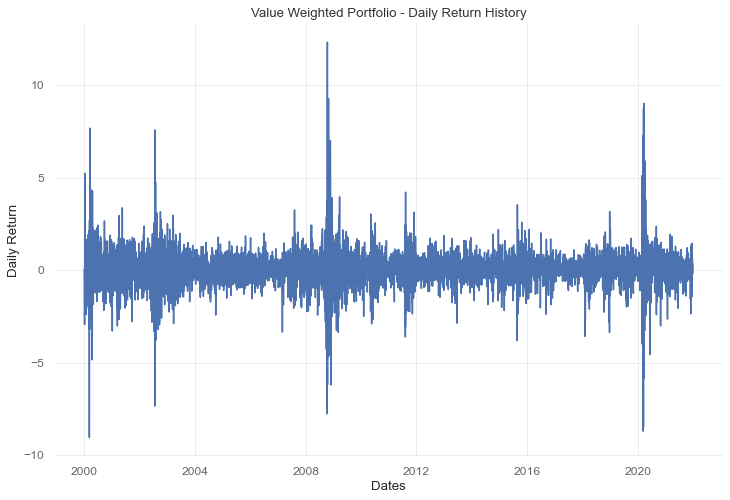

In [16]:
df_bm = df_bm.reset_index()
plt.figure(figsize=(12,8))
plt.plot(df_bm["date"],df_bm["ret_bm"])
plt.xlabel("Dates")
plt.ylabel("Daily Return")
plt.title("Value Weighted Portfolio - Daily Return History")
plt.show()

In [17]:
def dist_plot(df1):
    sns.kdeplot(df1,
                fill = True,
                label = "Returns", color ="green")
    plt.legend(loc = "upper right")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    pass

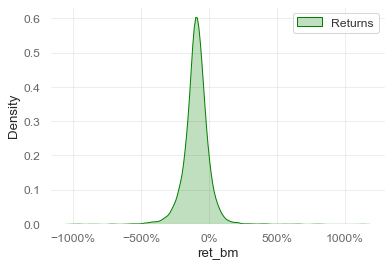

In [18]:
dist_plot(df_bm.ret_bm - 1)

Text(0.5, 1.0, 'Value Weighted Portfolio - Cumulative Product')

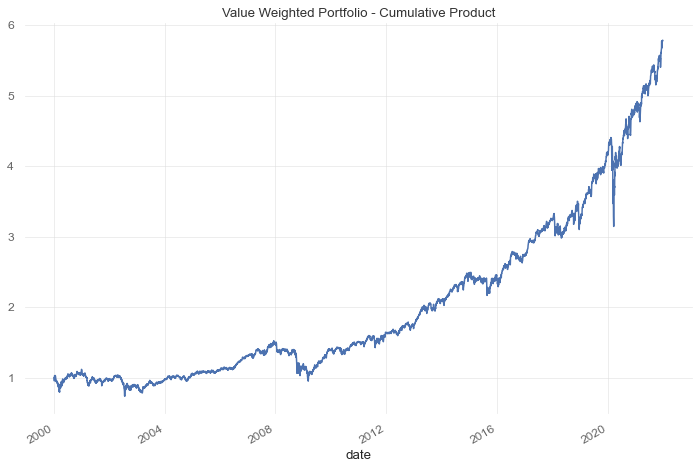

In [20]:
df_bm.set_index("date", inplace = True)
df_bm.ret_bm = df_bm.ret_bm/100
df_bm.ret_bm +=1
df_bm
df_bm["ret_bm"].cumprod().plot(figsize=(12,8))
plt.title('Value Weighted Portfolio - Cumulative Product')

In [21]:
df_bm.head(3)

,ret_bm
date,
1999-12-31,1.000602
2000-01-03,0.982142
2000-01-04,0.970578


In [22]:
df.head(3)

ret       mktcap    fret1d    fret5d    mom12m  \
permno  date                                                              
10874.0 2004-04-05  0.013269  3883.782171 -0.002619 -0.021905  1.199157   
        2004-04-06 -0.002619  3935.316000 -0.003581 -0.006923  1.219418   
        2004-04-07 -0.003581  3925.009163 -0.014854  0.004791  1.263542   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  ...  \
permno  date                                                            ...   
10874.0 2004-04-05  0.442925  0.067887    0.929207  0.021911  0.135846  ...   
        2004-04-06  0.429375  0.039712    0.927334  0.000899  0.078156  ...   
        2004-04-07  0.462696  0.010654    0.924014 -0.019639  0.076406  ...   

                    iv_atmsq  put_skewsq  call_skewsq  iv_atm_put_skew  \
permno  date                                                             
10874.0 2004-04-05  0.048067    0.095849     0.044477         0.067876   
        2004-04-06  0.051939    0.106832     0.050491         0.074490   
        2004-04-07  0.049521    0.112751     0.049168         0.074723   

                    iv_atm_call_skew  put_skew_call_skew  constant  \
permno  date                                                         
10874.0 2004-04-05          0.046237            0.065292       1.0   
        2004-04-06          0.051210            0.073445       1.0   
        2004-04-07          0.049344            0.074456       1.0   

                    percentage_market_cap  weights  ret_bm  
permno  date                                                
10874.0 2004-04-05               0.341163      NaN     NaN  
        2004-04-06               0.344709      NaN     NaN  
        2004-04-07               0.343095      NaN     NaN  

[3 rows x 44 columns]

In [23]:
df_bm.head()

,ret_bm
date,
1999-12-31,1.000602
2000-01-03,0.982142
2000-01-04,0.970578
2000-01-05,1.003304
2000-01-06,1.019351


In [24]:
df_bm['cumulative_returns'] = (df_bm['ret_bm']).rolling(window=20).apply(lambda x: x.prod(), raw=True) - 1
merged_df_2 = pd.merge(df,df_bm, on=['date'], how='left')
df.reset_index(inplace=True)
df.set_index('date')
df['cum_ret'] = merged_df_2['cumulative_returns'].values
df['cum_fret1d'] = (1 + df["fret1d"]).rolling(window=20).apply(lambda x: x.prod(), raw=True) - 1
df.set_index(['permno', 'date'])

ret        mktcap    fret1d    fret5d    mom12m  \
permno  date                                                               
10874.0 2004-04-05  0.013269   3883.782171 -0.002619 -0.021905  1.199157   
        2004-04-06 -0.002619   3935.316000 -0.003581 -0.006923  1.219418   
        2004-04-07 -0.003581   3925.009163 -0.014854  0.004791  1.263542   
        2004-04-08 -0.014854   3910.954677  0.017510  0.034776  1.352782   
        2004-04-12  0.017510   3852.861660 -0.018164  0.014579  1.390541   
...                      ...           ...       ...       ...       ...   
88664.0 2021-11-12 -0.009233  11788.068107 -0.004691 -0.028718  0.029657   
        2021-11-15 -0.004691  11679.227747  0.004076 -0.024331  0.055661   
        2021-11-16  0.004076  11624.437000 -0.024359 -0.029180  0.059646   
        2021-11-17 -0.024359  11671.823195 -0.013004 -0.006437  0.066143   
        2021-11-18 -0.013004  11387.506026  0.009289 -0.004348  0.093763   

                       mom6m     rev1m  beta_mktrf  beta_smb  beta_hml  ...  \
permno  date                                                            ...   
10874.0 2004-04-05  0.442925  0.067887    0.929207  0.021911  0.135846  ...   
        2004-04-06  0.429375  0.039712    0.927334  0.000899  0.078156  ...   
        2004-04-07  0.462696  0.010654    0.924014 -0.019639  0.076406  ...   
        2004-04-08  0.483999 -0.000486    0.921625 -0.003121  0.085215  ...   
        2004-04-12  0.491957  0.064090    0.924204 -0.002850  0.064028  ...   
...                      ...       ...         ...       ...       ...  ...   
88664.0 2021-11-12  0.059887 -0.060960    0.836499 -0.439657  0.007731  ...   
        2021-11-15  0.063485 -0.076796    0.836389 -0.436316  0.005635  ...   
        2021-11-16  0.061220 -0.078398    0.871926 -0.411568  0.007264  ...   
        2021-11-17  0.049809 -0.100322    0.881072 -0.406322  0.008678  ...   
        2021-11-18  0.035045 -0.112696    0.889982 -0.397461  0.005551  ...   

                    call_skewsq  iv_atm_put_skew  iv_atm_call_skew  \
permno  date                                                         
10874.0 2004-04-05     0.044477         0.067876          0.046237   
        2004-04-06     0.050491         0.074490          0.051210   
        2004-04-07     0.049168         0.074723          0.049344   
        2004-04-08     0.060748         0.074988          0.055662   
        2004-04-12     0.053271         0.081532          0.053596   
...                         ...              ...               ...   
88664.0 2021-11-12     0.078568         0.088883          0.064273   
        2021-11-15     0.109177         0.078915          0.079243   
        2021-11-16     0.123101         0.112746          0.085535   
        2021-11-17     0.115631         0.104191          0.081804   
        2021-11-18     0.068018         0.093101          0.064778   

                    put_skew_call_skew  constant  percentage_market_cap  \
permno  date                                                              
10874.0 2004-04-05            0.065292       1.0               0.341163   
        2004-04-06            0.073445       1.0               0.344709   
        2004-04-07            0.074456       1.0               0.343095   
        2004-04-08            0.081839       1.0               0.343104   
        2004-04-12            0.081038       1.0               0.339154   
...                                ...       ...                    ...   
88664.0 2021-11-12            0.108652       1.0               0.336466   
        2021-11-15            0.108725       1.0               0.331707   
        2021-11-16            0.162264       1.0               0.329299   
        2021-11-17            0.147277       1.0               0.330316   
        2021-11-18            0.097757       1.0               0.323841   

                     weights    ret_bm   cum_ret  cum_fret1d  
permno  date                                              

In [25]:
#df = df.set_index(['permno', 'date']).sort_index()
bnch_wts=df["weights"]
bnch_wts


0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
201072    0.379161
201073    0.379161
201074    0.379161
201075    0.379161
201076    0.379161
Name: weights, Length: 201077, dtype: float64

### 5. Backtesting Class:

In [26]:
# suppliment functions (all of them are static)
def beta_constraint(wvec,betas, target = 0.5):
    return wvec@betas-target
    
hex(id(beta_constraint))

def winsorize_df(df, feature_names, level_winsorize):
    df = df.copy()
    for ft in feature_names:
        goods    = df[ft].notna()
        df.loc[goods, ft] = winsorize(df.loc[goods,ft], limits=level_winsorize).data
    return df
    
# Apply the maximum absolute scaling in Pandas using the .abs() and .max() methods
def maximum_absolute_scaling(df, columns):
    df = df.copy()
    # apply maximum absolute scaling
    for column in columns:
        df[column ] = df[column]  / df[column].abs().max()
    return df

# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df, columns):
    df = df.copy()
    # apply min-max scaling
    for column in columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())      
    return df

# Apply the Z-score absolute scaling in Pandas using the .abs() and .max() methods
def z_score_scaling(df, columns):
    df = df.copy()
    # apply maximum absolute scaling
    for column in columns:
        df[column] = (df[column] - df[column].mean())  / df[column].abs().max()
    return df

def find_max_corr_feature(df, feature_names_subset, label):
    max_corr = -100000
    var_max = None
    for ft in feature_names_subset:
        cr = np.abs(df[[ft] + [label]].corr()[label].values[0])
        #print(ft + ': ' + str(cr))
        if cr > max_corr:
            max_corr = cr
            var_max = ft
    return var_max

def parse_features(df, feature_names, level_winsorize):
    df = df.copy().dropna()
    for ft in feature_names:
        # winsorise
        df[ft] = winsorize(df[ft], limits=level_winsorize).data

        # apply cox-box transform
        var_norm, lambda_ = stats.boxcox(df[ft] - df[ft].min() +0.0001)
        if lambda_ < 5:
            #print(ft + ': optimal lambda = ' + str(lambda_))
            df[ft] = var_norm
        else:
            print(ft + ' procedure failed, skipping cox box tranformation')
        
        #apply z-score scaling
        df[ft] = (df[ft] - df[ft].mean())  / df[ft].abs().max()
    return df

def forward_selection(df, label, feature_names):
    df = df.copy()
    df['const'] = 1
    feature_names_initial = feature_names.copy()
    feature_names = feature_names.copy()
    rsquared_adj_max = -10000
    ft_selected = []
    for ft in feature_names_initial:
        # find most correlated
        ft_hc = find_max_corr_feature(df, feature_names, label)
        model = sm.OLS(df[label], df[['const'] + ft_selected + [ft_hc]], missing = "drop")
        results = model.fit()
        if results.rsquared_adj > rsquared_adj_max:
            ft_selected.append(ft_hc)
            #print(results.summary())
            #print('Parameters: ', results.params)
            #print('R2_adj: ', results.rsquared_adj)
            feature_names.remove(ft_hc)
            #print(feature_names)
            rsquared_adj_max = results.rsquared_adj
        else:
            prm = {}
            for ft in ft_selected:
                prm[ft] = results.params[ft]
            return prm, rsquared_adj_max
        pass
    prm = {}
    for ft in ft_selected:
        prm[ft] = results.params[ft]
    return prm, rsquared_adj_max

def gramm_schmidt(df, label, feature_names):
    df = df.copy()
    df['const'] = 1
    feature_names_initial = feature_names.copy()
    feature_names = feature_names.copy()
    rsquared_adj_max = -10000
    ft_selected = []
    prm = {}
    for ft in ft_selected:
        prm[ft] = 0
    for ft in feature_names_initial:
        # find most correlated
        ft_hc = find_max_corr_feature(df, feature_names, label)
        y = df[label]
        if len(ft_selected) > 0:
            y = resid
            pass
        model = sm.OLS(y, df[['const'] + [ft_hc]], missing = "drop")
        results = model.fit()
        
        if results.rsquared_adj > rsquared_adj_max:
            ft_selected.append(ft_hc)
            resid = results.resid
            feature_names.remove(ft_hc)
            rsquared_adj_max = results.rsquared_adj
            prm[ft_hc] = results.params[ft_hc]
        else:
            feature_names.remove(ft_hc)
    #         for ft in ft_selected:
    #             if ft in results.params:
    #                 prm[ft] = results.params[ft]
    #         return prm, rsquared_adj_max
    # for ft in ft_selected:
    #     if ft in results.params:
    #         prm[ft] = results.params[ft]
    return prm, rsquared_adj_max

def ridge_regression(df, alpha, label, feature_names):
    #Fit the model
    ridgereg = Ridge(alpha=alpha)
    ridgereg.fit(df[feature_names],df[label])
    y_pred = ridgereg.predict(df[feature_names])
    
    #Return the result in pre-defined format
    rss = sum((y_pred-df[label])**2)
    r_2 = ridgereg.score(df[feature_names],df[label])
    ret = []
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    # print(ridgereg)
    return ret, r_2

def lasso_regression(df,alpha, label, feature_names):
    #Fit the model
    lassoreg = Lasso(alpha=alpha, max_iter=int(1e5))
    lassoreg.fit(df[feature_names],df[label])
    y_pred = lassoreg.predict(df[feature_names])

    #Return the result in pre-defined format
    rss = sum((y_pred-df[label])**2)
    r_2 = lassoreg.score(df[feature_names],df[label])
    ret = []
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    # print(lassoreg)
    return ret, r_2

def apply_LGBM(self, df, label, feature_names):
    params = {
        'objective': 'regression',
        'device': 'cpu',
        'boosting': 'goss',
        # method of boosting (gbdt, rf, dart, goss) --> dart<gbdt<goss ( provides a new sampling method for GBDT by separating those instances with larger gradients)
        # 'num_iterations': 100,
        'lambda_l1': 20,  # L1 regularization ---> reduces both overfitting and test error
        'lambda_l2': 1,  # L2 regularization
        'max_depth': -1,  # limit the max depth for tree model
        'max_bin': 500,  # Small number of bins may reduce training accuracy but can deal with over-fitting
        # 'num_leaves': 100,  # max number of leaves in one tree
        'colsample_bytree': 0.8,  # % features used while const tree
        'subsample': 1,  # subsample ratio of the training instance
        'learning_rate': 0.02,
        'metric': 'rmse',
        'verbose': -1  # debugging

    }
    # mdl = lgb.LGBMRegressor(params)
    # loading data
    lgb_train = lgb.Dataset(df[feature_names],
                            df[label])
    # Fit the model
    lgb_model = lgb.train(params,
                            train_set=lgb_train,
                            valid_sets=lgb_train,
                            callbacks=[early_stopping(stopping_rounds=5,verbose = False)]
                            # early_stopping_rounds=5,
                            # verbose_eval = -1
                            )

    y_pred = lgb_model.predict(df[feature_names])

    # Return the result in pre-defined format
    
    r_2 = metrics.r2_score(y_pred, df[label])

    return lgb_model
    
def restrict_trading_universe(df, n_stocks):
    df = df.copy()
    permnos = df.loc[df.date==df.date.max(), ['permno', 'mktcap']].drop_duplicates().\
                sort_values('mktcap', ascending=True)[0:n_stocks]['permno'].values
    return df.loc[df.permno.isin(permnos)]

In [27]:
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])

In [28]:
def MaxRet(wvec,*args):
     mu = args[1]
     return -wvec@mu

def MVP(wvec,*args):
     cov = args[0]
     var = wvec@cov@wvec
     return var*1e3

def MSR(wvec,*args):
     cov = args[0]
     mu  = args[1]
     sr = mu@wvec/(wvec@cov@wvec)
     return -sr*1e3 

def optimize(cov, mu, fun, cons, bounds):
    N = len(mu)

    res = minimize(fun,
                    np.ones(N)/N,
                    args = (cov, mu), 
                    constraints = cons, 
                    bounds = bounds, 
                    method = 'SLSQP',
                    options={'ftol': 1e-10, 'disp': False})
    return res

def test_strategy_mv(**kwargs):
     cov = kwargs.get('cov')
     NA = cov.shape[0]
     mu = kwargs.get('mu',np.ones(NA))
     ret_fw = kwargs.get('ret_fw',mu)
     method = kwargs.get('method','minvar')
    
     if method == 'minvar':
         w = np.linalg.inv(cov)@np.ones(NA)
         pass
     else:
         w = np.linalg.inv(cov)@mu
         pass
     w = w/np.nansum(w)
    
     return w@ret_fw, w
      

In [29]:
class Backtester:
    dates_rebalance = None
    rolling_frq = None
    df = None
    look_back_prm = None
    n_stocks = None
    optimal_weights = None
    print_results_bool = True
    level_winsorize = None
    
    def __init__(self, 
                 df, 
                 rolling_frw,
                 look_back_prm,
                 n_stocks,
                 level_winsorize,
                 configurations,
                 print_results):
        
        print('Initialising backtester class.. ')
        self.rolling_frq = rolling_frw
        self.df = df
        self.look_back_prm = look_back_prm
        self.n_stocks = n_stocks
        self.configurations=configurations
        self.level_winsorize = level_winsorize
        self.print_results_bool = print_results
        self.dates = []
        self.optimal_weights = {}
        self.returns_strategy = {}
        for key in configurations.keys():
            self.optimal_weights[key] = self.df[['permno', 'date']].copy().set_index(['permno', 'date'])
            self.optimal_weights[key]['weight'] = 0
            self.returns_strategy[key] = self.df[['date']].copy().drop_duplicates().set_index(['date'])
            self.returns_strategy[key]['return'] = None
            self.returns_strategy[key].index = pd.to_datetime(self.returns_strategy[key].index)
        print('..done')

    def make_prediction(self, df_out_sample, prm, model_type = 'linear', features_names= None):
        df_pred = df_out_sample.copy()
        df_pred['pred'] = 0
        const = 0
        if model_type =='linear':
            for ft, prm_ft in prm.items():
                if ft.lower() in ['const', 'constant', 'intercept']:
                    const = prm_ft
                else:
                    df_pred['pred'] += df_pred[ft] * prm_ft
                pass
            df_pred['pred'] += const
            
        else: 
            model = prm
            df_pred['pred'] = model.predict(df_pred[features_names])
        return df_pred

        
    def get_n_days_rolling(self):
        if self.rolling_frq == '1M':
            return 30
        elif self.rolling_frq == '1W':
            return 7
        elif self.rolling_frq == '1D':
            return 1
        else:
            print('rolling_frq not supported: ' + self.rolling_frq)
            
    def parse_data(self, df_r, level_winsorize):
        return parse_features(df_r, feature_names, level_winsorize)
    
    def alpha_estimation(self, df_r, alpha_estimation_method, label, feature_names):
        alpha_estimation_name = alpha_estimation_method['name']
        kwargs = alpha_estimation_method.get('kwargs', {})
        if alpha_estimation_name == 'FrwdSelection':
            prm = self.estimate_forward_selection_method(df_r,label = label, feature_names=feature_names)
        elif alpha_estimation_name == 'RidgeRegression':
            prm = self.estimate_ridge_regression(df_r,label = label, feature_names=feature_names, **kwargs)
        elif alpha_estimation_name == 'LassoRegression':
            prm =self.estimate_lasso_regression(df_r,label = label, feature_names=feature_names, **kwargs)
        elif alpha_estimation_name == 'GrammSchmidt':
            prm = self.estimate_gramm_schmidt(df_r,label = label, feature_names=feature_names)
        elif alpha_estimation_name == 'LGBM':
            prm = self.estimate_LGBM(df_r, label = label, feature_names=feature_names)
        else:
            print('Method is not supported: ' + alpha_estimation_method )
            prm = None
        # print(f'{alpha_estimation_name} {kwargs} optimal parameters: {prm}')
        return prm
    
    def estimate_forward_selection_method(self, df_r,label, feature_names):
        prm, rsquared_adj_max = forward_selection(df_r, label= label,feature_names=feature_names)
        # print('test r_adj = ' + str(rsquared_adj_max))
        #print('optimal model = ' + str(prm)) 
        return prm
    
    def estimate_gramm_schmidt(self, df_r,label, feature_names):
        prm, rsquared_adj_max = gramm_schmidt(df_r, label= label,feature_names=feature_names)
        # print('test r_adj = ' + str(rsquared_adj_max))
        #print('optimal model = ' + str(prm)) 
        return prm
        
    def estimate_ridge_regression(self, df_r,label, feature_names, alpha = 1):
        ft_selected, rsquared_adj_max = ridge_regression(df_r, alpha =alpha, label= label,feature_names=feature_names)
        # print('test r_adj = ' + str(rsquared_adj_max))
        #print('optimal model = ' + str(ft_selected)) 
        # HERE WE HAD A BUG -- ASSIGNED CONSTANT TO A FIRST FEATURE.. ETC. WRONG COEFFICIENTS SAVED FOR ALL FEATURES
        prm = {}
        for i,ft in enumerate(['constant']+feature_names):
            prm[ft] = ft_selected[i]
        return prm
        
    def estimate_lasso_regression(self, df_r, label, feature_names, alpha = 1e-5):
        ft_selected, rsquared_adj_max = lasso_regression(df_r, alpha = alpha, label= label,feature_names=feature_names)
        # print('test r_adj = ' + str(rsquared_adj_max))
        #print('optimal model = ' + str(ft_selected)) 
        # HERE WE HAD A BUG -- ASSIGNED CONSTANT TO A FIRST FEATURE.. ETC. WRONG COEFFICIENTS SAVED FOR ALL FEATURES
        prm = {}
        for i,ft in enumerate(['constant']+feature_names):
            prm[ft] = ft_selected[i]
        return prm

    
    def estimate_LGBM(self, df_r, label , feature_names):
        prm = apply_LGBM(self,df_r, label, feature_names)
        return prm
    
    def prepare_inputs_for_optimisation(self, df_r, df_out_sample, label):   
        #take the list of names that are present in both insample and out of sample datatset
        #we need that to have exactly the same stock that we make prediction for in the out of sample
        permnos = list(set(df_r['permno'].unique()).intersection(df_out_sample['permno'].unique()))
        df_r = df_r[df_r['permno'].isin(permnos)]
        df_out_sample = df_out_sample[df_out_sample['permno'].isin(permnos)]
        
        #rearrange the forward returns to a matrix
        ret = pd.pivot_table(df_r, values=label, index=['date'], columns=['permno'])
        ret = ret.fillna(0.0)
        
        #rearrange the predicted returns to a matrix
        expret = pd.pivot_table(df_out_sample[df_out_sample['permno'].isin(permnos)], 
                                values='pred', index=['date'], columns=['permno'])
        expret = expret.fillna(0.0)
        
        # calculate covariance between returns using insample data
        # in practive we use a risk model here (barrs, axioma)
        r1d = pd.pivot_table(df_r, values='ret', index=['date'], columns=['permno'])
        r1d = r1d.fillna(0.0)
        cov = r1d.cov().values
    
        stock_ids = list(expret.columns)
        
        #we have predicted returns for each day, take the last day in our period
        expret = expret.iloc[0].values
        
        #rearrange realised returns to simplify strategy return calculation
        realised_ret= pd.pivot_table(df_out_sample, values='fret1d', index=['date'], columns=['permno'])
        realised_ret.index = pd.to_datetime(realised_ret.index)
        realised_ret.fillna(0, inplace=True)
        
        #define constraints
        cons = []
        
        N = len(expret)
        
        betas_df = pd.pivot_table(df_out_sample, values='betas', index=['date'], columns=['permno'])   
        
        betas = betas_df.iloc[0,:].values.flatten()
        
        def beta_constraint(wvec,betas, target = 0.5):
            return wvec@betas-target
        
        
        bnch_weights_df = pd.pivot_table(df_out_sample, values='weights', index=['date'], columns=['permno'])
        bnch_weights = bnch_weights_df.iloc[0,:].values.flatten()
        
        def weight_deviation_constraint(wvec, bnch_weights, target =0.1):
            return -(np.abs(wvec-bnch_weights) - target * bnch_weights)
            

        bnch_df = pd.pivot_table(df_out_sample, values='cum_ret', index=['date'], columns=['permno'])
        bnch_ret = bnch_df.iloc[0,:].values.flatten()
        
        portfolio_ret_df = pd.pivot_table(df_out_sample, values='cum_fret1d', index=['date'], columns=['permno'])
        portfolio_ret = bnch_df.iloc[0,:].values.flatten()
        
        def drawdown_constraint(wvec,portfolio_ret,bnch_ret, target=0.01):
            return target-((bnch_ret-(wvec@portfolio_ret))/bnch_ret)
        
        # define constraints
        cons = [ {'type': 'eq', 'fun' : lambda wvec: wvec.sum()-1},
                {'type': 'eq', 'fun' : beta_constraint, 'args': (betas,) },
                {'type': 'ineq', 'fun' : weight_deviation_constraint, 'args': (bnch_weights,)},
                {'type': 'ineq', 'fun' : drawdown_constraint, 'args': (portfolio_ret,bnch_ret,)} ] 
        
        # define bounds
        bounds = [[-0.25, 0.25] for z in range(N)]
        
        return cov, expret, realised_ret, cons, bounds, stock_ids, betas_df

    def print_results(self):
        # descriptive stats of performance
        for run_name, cfg in self.configurations.items():
            print('Analysis of the result for configuration: ' + run_name)
            ret = self.returns_strategy[run_name].dropna()
            ret.cumsum().plot()
            print('Sharpe ratio = ' + str(ret['return'].mean()/ret['return'].std()*np.sqrt(252)))
            print('Annual return = ' + str(ret['return'].sum()))
            print('Average daily return (bps)= ' + str(ret['return'].mean()* 1e4))
            qs.reports.full(ret['return'])
            print('****************************************')


    def backtest(self,dt):
        print('for date: ' + str(dt))
        returns_strategy = pd.DataFrame(columns= self.configurations.keys())
        optimal_weights = {}
        # for key in configurations.keys():
        #     returns_strategy[key] = self.df[['date']].copy().drop_duplicates().set_index(['date'])
        for cfg_name, cfg in self.configurations.items():
            # print('processing configuration: ' + cfg_name)
            model_type = cfg['model_type']
            #############################################
            ### ASSIGN CONFIGURATION PARAMETERS #########
            last_day_shift = cfg.get('last_day_shift', 5)
            label = cfg.get('label', 'fret5d')
            features = cfg.get('features', None)
            alpha_estimation_method = cfg['alpha_estimation_method']
            parsing_pipe = cfg.get('parsing',None)
            model_type = cfg.get('model_type',"linear")
            #############################################
            if features is None: 
                print(f'No features specified for {cfg_name}')
                break

            # step0: restrict universe to speed up calculations (remove later):
            df = restrict_trading_universe(self.df, self.n_stocks)

            # step1: restrict dataset to insample
            ######
                #please note the change to the first version - we shifted the dates by 5 days to avoid look ahead bias
            #####
            # print('step1: restrict dataset to insample')
            df_r = df.loc[np.logical_and(
                df['date'] >= dt - pd.Timedelta(days=self.look_back_prm), 
                df['date'] < dt - pd.Timedelta(days = last_day_shift)), :].copy()
            # print('       insample period, start date: ' + 
            #       str(df_r['date'].min()) + 
            #       ' end date = ' + 
            #       str(df_r['date'].max()))

            # step2: prepare data - filter out outlier, normalise, winsorise, cox-box trasnform
            # print('step2: prepare data in-sample')
            if parsing_pipe is not None: 
                df_r[features] = parsing_pipe.fit_transform(df_r[features])
            else:
                df_r = self.parse_data(df_r, self.level_winsorize)

            # step3: run alpha estimation method
            # print(f'step3: run alpha estimation method: {alpha_estimation_method}')
            prm = self.alpha_estimation(df_r, 
                                        alpha_estimation_method=alpha_estimation_method, 
                                        label=label, 
                                        feature_names = features)

            # step4: set out of sample period 
            # print('step4: set out of sample period')
            sel = np.logical_and(
                df['date'] >= dt, 
                df['date'] < dt + pd.Timedelta(days=self.get_n_days_rolling()))
            if sum(sel)==0:
                continue
                
            df_out_sample = df.loc[sel, :].copy()
            # print('       out of sample period, start date: ' + 
            #       str(df_out_sample['date'].min()) + 
            #       ' end date = ' + 
            #       str(df_out_sample['date'].max()))

            # step5: prepare out of data (only factors!) 
            # - filter out outlier, normalise, winsorize, cox-box transform
            # print('step5: prepare out of data (only factors!)')
            if parsing_pipe is not None:
                df_out_sample[features] = parsing_pipe.transform(df_out_sample[features])
            else: 
                df_out_sample = self.parse_data(df_out_sample, self.level_winsorize)

            #step6: make prediction for out of sample
            # print('step6: make prediction for out of sample')
            df_pred = self.make_prediction(df_out_sample, prm, model_type = model_type,features_names=features)
            #print(df_pred.head())

            #step7: estimate covarinace and prepare inputs for optimisation
            # print('    step7: estimate covariance and prepare inputs for optimisation')
            cov, expret, realised_ret, cons, bounds, stock_ids, betas_df = \
                self.prepare_inputs_for_optimisation(df_r, df_pred, label = label)
            
            #step8: solve optimisation problem
            # print('    step8: solve optimisation problem')
            res = optimize(cov, expret, cfg['opt_function'], cons, bounds)
            # res.x are the optimal weight that we were looking for....
            # for d in pd.date_range(dt, dt + pd.Timedelta(days=self.get_n_days_rolling()-1)):
            #     self.optimal_weights[cfg_name].loc[d, stock_ids] = res.x
            #     if d in realised_ret.index:
            #         self.returns_strategy[cfg_name].loc[d] = res.x@realised_ret.loc[d]
            #         print(f'realized betas for {d}: {res.x@betas_df.loc[d]}')
                    
            for d in pd.date_range(dt, dt + pd.Timedelta(days=self.get_n_days_rolling()-1)):
                # optimal_weights[cfg_name].loc[d, stock_ids] = res.x

                if d in realised_ret.index:
                    # returns_strategy.loc[d,cfg_name] = np.nansum(res.x.T*realised_ret.loc[d])
                    # returns_strategy.loc[d,cfg_name] = np.dot(res.x,realised_ret.loc[d])
                    returns_strategy.loc[d,cfg_name] = res.x@realised_ret.loc[d]
                    
                    # print(f'realized betas for {d}: {res.x@betas_df.loc[d]}')
            # for d in pd.date_range(dt, dt + pd.Timedelta(days=self.get_n_days_rolling()-1)):
            #     optimal_weights[cfg_name].loc[d, stock_ids] = res.x
            #     if d in realised_ret.index:
            #         returns_strategy[cfg_name].loc[d] = res.x@realised_ret.loc[d]
            #         print(f'realized betas for {d}: {res.x@betas_df.loc[d]}')
        return returns_strategy


    def run_backtest_parallel(self):
        print('running backtest parallel...')
        results = []
        dt_list = pd.date_range(start=self.df['date'].min() + pd.Timedelta(days=self.look_back_prm),
                                end=self.df['date'].max() - pd.Timedelta(days=self.get_n_days_rolling()+1), 
                                freq=self.rolling_frq)

        with Parallel(n_jobs=CPUUsed) as parallel:
            results  = parallel(delayed(self.backtest)(dt) for dt in dt_list)
        
        bk_results = pd.concat(results)
        for col in bk_results.columns:
            bk_results[col] = pd.to_numeric(bk_results[col])
        return bk_results

## Backtest Testing functions:
    def test_function(self,dt):
        res = pd.DataFrame(columns= self.configurations.keys())
        for key in self.configurations.keys():
            res.loc[dt,key] = 1
        return(res)


    def run_backtest_parallel_test(self):
        print('running backtest parallel...')
        results = []
        dt_list = pd.date_range(start=self.df['date'].min() + pd.Timedelta(days=self.look_back_prm),
                                end=self.df['date'].max() - pd.Timedelta(days=self.get_n_days_rolling()+1), 
                                freq=self.rolling_frq)
        with Parallel(n_jobs=CPUUsed) as parallel:
            results  = parallel(delayed(self.test_function)(dt) for dt in dt_list)
        
        return pd.concat(results)

In [30]:
df.columns

Index(['index', 'permno', 'date', 'ret', 'mktcap', 'fret1d', 'fret5d',
       'mom12m', 'mom6m', 'rev1m', 'beta_mktrf', 'beta_smb', 'beta_hml',
       'beta_mom', 'idvar_ff4', 'secid', 'iv_atm', 'put_skew', 'call_skew',
       'skew', 'glb2_D30', 'glb3_D30', 'glb2_D91', 'glb3_D91', 'glb2_D182',
       'glb3_D182', 'glb2_D273', 'glb3_D273', 'glb2_D365', 'glb3_D365',
       'mom12msq', 'mom6msq', 'rev1msq', 'beta_mktrfsq', 'beta_smbsq',
       'beta_hmlsq', 'beta_momsq', 'iv_atmsq', 'put_skewsq', 'call_skewsq',
       'iv_atm_put_skew', 'iv_atm_call_skew', 'put_skew_call_skew', 'constant',
       'percentage_market_cap', 'weights', 'ret_bm', 'cum_ret', 'cum_fret1d'],
      dtype='object')

### 6. Trials

This section consists of:

1. [Configuration Space](#1-configuration-space)
2. [Training period (2000 - 2015)](#2-training-period-2000---2015)
3. [Testing period (2016-2021)](#3-testing-period-2016---2021)
4. [All]()

#### 1. Configuration Space

In [31]:
# Beta column for the constraint function
df['betas'] = df['beta_mktrf']
df.head(3)

feature_glb = list(glb_daily.columns)
features = feature_names[:-1] + feature_sq + feature_combo + feature_glb
features

# pipeqt = Pipeline([('ws',Winsorize(level_winsorize = 0.01)),
#                 ('qt',QuantileTransformer(output_distribution='uniform',n_quantiles=100)),
#                 ('maxabs',MaxAbsScaler())])

pipept = Pipeline([('ws',Winsorize(level_winsorize = 0.01)),
                ('qt',PowerTransformer()),
                ('maxabs',MaxAbsScaler())])

configurations = {
                    'MVP_GrammSchmidt': {'opt_function': MVP,
                                        'alpha_estimation_method':{'name':'GrammSchmidt'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear'},
                    'MVP_FrwrdSelection': {'opt_function': MVP,
                                        'alpha_estimation_method': {'name': 'FrwdSelection'},
                                        'label':'fret5d',
                                        'last_day_shift':5,
                                        'features':features,
                                        'model_type':'linear',
                                        'parsing':clone(pipept)},
                    'MVP_LASSO': {'opt_function': MVP,
                                        'alpha_estimation_method':{'name':'LassoRegression', 'kwargs':{'alpha':0.01}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear',
                                        'parsing':clone(pipept)},
                    'MVP_RIDGE': {'opt_function': MVP,
                                        'alpha_estimation_method':{'name':'RidgeRegression', 'kwargs':{'alpha':1}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear',
                                        'parsing':clone(pipept)},                          
                    'MVP_LGBM': {'opt_function': MVP,
                                        'alpha_estimation_method':{'name':'LGBM'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'Non_linear'},

                    'MSR_FrwdSelection': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'FrwdSelection'},
                                       'label':'fret5d',
                                       'last_day_shift':5, 
                                       'features': features,
                                       'model_type':'linear'},
                                       
                    'MSR_GrammSchmidt': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'GrammSchmidt'},
                                       'label':'fret5d',
                                       'last_day_shift':5, 
                                       'features': features,
                                       'model_type':'linear'}, 
                    'MSR_LASSO': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'LassoRegression', 'kwargs':{'alpha':0.01}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear'},
                    'MSR_RIDGE': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'RidgeRegression', 'kwargs':{'alpha':1}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'linear'},
                    'MSR_LGBM': {'opt_function': MSR,
                                        'alpha_estimation_method':{'name':'LGBM'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'Non_linear'},

                    'MaxRet_FrwrdSelection': {'opt_function': MaxRet,
                                        'alpha_estimation_method': {'name': 'FrwdSelection'},
                                        'label':'fret5d',
                                        'last_day_shift':5,
                                        'model_type':'linear',
                                        'features':features},
                    'MaxRet_GrammSchmidt': {'opt_function': MaxRet,
                                        'alpha_estimation_method':{'name':'GrammSchmidt'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'model_type':'linear',
                                        'features': features}, 
                    'MaxRet_LASSO': {'opt_function': MaxRet,
                                        'alpha_estimation_method':{'name':'LassoRegression', 'kwargs':{'alpha':0.01}},
                                        'label':'fret5d',
                                        'last_day_shift':5,
                                        'model_type':'linear', 
                                        'features': features},
                    'MaxRet_RIDGE': {'opt_function': MaxRet,
                                        'alpha_estimation_method':{'name':'RidgeRegression', 'kwargs':{'alpha':1}},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'model_type':'linear',
                                        'features': features},
                    'MaxRet_LGBM': {'opt_function': MaxRet,
                                        'alpha_estimation_method':{'name':'LGBM'},
                                        'label':'fret5d',
                                        'last_day_shift':5, 
                                        'features': features,
                                        'model_type':'Non_linear'},

}


In [32]:
features

['mom12m',
 'mom6m',
 'rev1m',
 'beta_mktrf',
 'beta_smb',
 'beta_hml',
 'beta_mom',
 'idvar_ff4',
 'iv_atm',
 'put_skew',
 'call_skew',
 'mom12msq',
 'mom6msq',
 'rev1msq',
 'beta_mktrfsq',
 'beta_smbsq',
 'beta_hmlsq',
 'beta_momsq',
 'iv_atmsq',
 'put_skewsq',
 'call_skewsq',
 'iv_atm_put_skew',
 'iv_atm_call_skew',
 'put_skew_call_skew',
 'glb2_D30',
 'glb3_D30',
 'glb2_D91',
 'glb3_D91',
 'glb2_D182',
 'glb3_D182',
 'glb2_D273',
 'glb3_D273',
 'glb2_D365',
 'glb3_D365']

In [33]:
### Run only 1 loop of the backtest:
rolling_frq = '1W'
look_back_prm = 2*365
dt_list = pd.date_range(start=df['date'].min() + pd.Timedelta(days=look_back_prm),
                                end=df['date'].max() - pd.Timedelta(days=7+1), 
                                freq=rolling_frq)

dt = dt_list[0]
bk_SC_config = Backtester(df=df[df.date <'2005-01-01'],
                rolling_frw = '1W',
                look_back_prm = 2*365,
                n_stocks = 50,
                level_winsorize = 0.001, # changing parameter to 0.01 for testing purposes.
                configurations = configurations,
                print_results=False)
bk_SC_config.backtest(dt)
#

Initialising backtester class.. 
..done
for date: 2001-12-30 00:00:00


,MVP_GrammSchmidt,MVP_FrwrdSelection,MVP_LASSO,MVP_RIDGE,MVP_LGBM,MSR_FrwdSelection,MSR_GrammSchmidt,MSR_LASSO,MSR_RIDGE,MSR_LGBM,MaxRet_FrwrdSelection,MaxRet_GrammSchmidt,MaxRet_LASSO,MaxRet_RIDGE,MaxRet_LGBM
2001-12-31,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263,0.012263
2002-01-02,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151,0.019151
2002-01-03,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125,0.00125
2002-01-04,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275,-0.008275


#### 2. Training Period:

In [34]:
# bk.print_results()
%load_ext autoreload
%autoreload 2

bk_train = Backtester(df=df[df.date <'2016-01-01'],
                rolling_frw = '1W',
                look_back_prm = 2*365,
                n_stocks = 50,
                level_winsorize = 0.01, # changing parameter to 0.01 for testing purposes.
                configurations = configurations,
                print_results=False)
res_train = bk_train.run_backtest_parallel()
end_time = time.time()
clear_output()


In [35]:
res_train.head()

,MVP_GrammSchmidt,MVP_FrwrdSelection,MVP_LASSO,MVP_RIDGE,MVP_LGBM,MSR_FrwdSelection,MSR_GrammSchmidt,MSR_LASSO,MSR_RIDGE,MSR_LGBM,MaxRet_FrwrdSelection,MaxRet_GrammSchmidt,MaxRet_LASSO,MaxRet_RIDGE,MaxRet_LGBM
2001-12-31,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.006731,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295,0.013295
2002-01-02,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.014314,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345,0.022345
2002-01-03,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001436,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428,0.001428
2002-01-04,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.006052,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101,-0.008101
2002-01-07,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450,-0.003451,-0.003450,-0.003452,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450,-0.003450


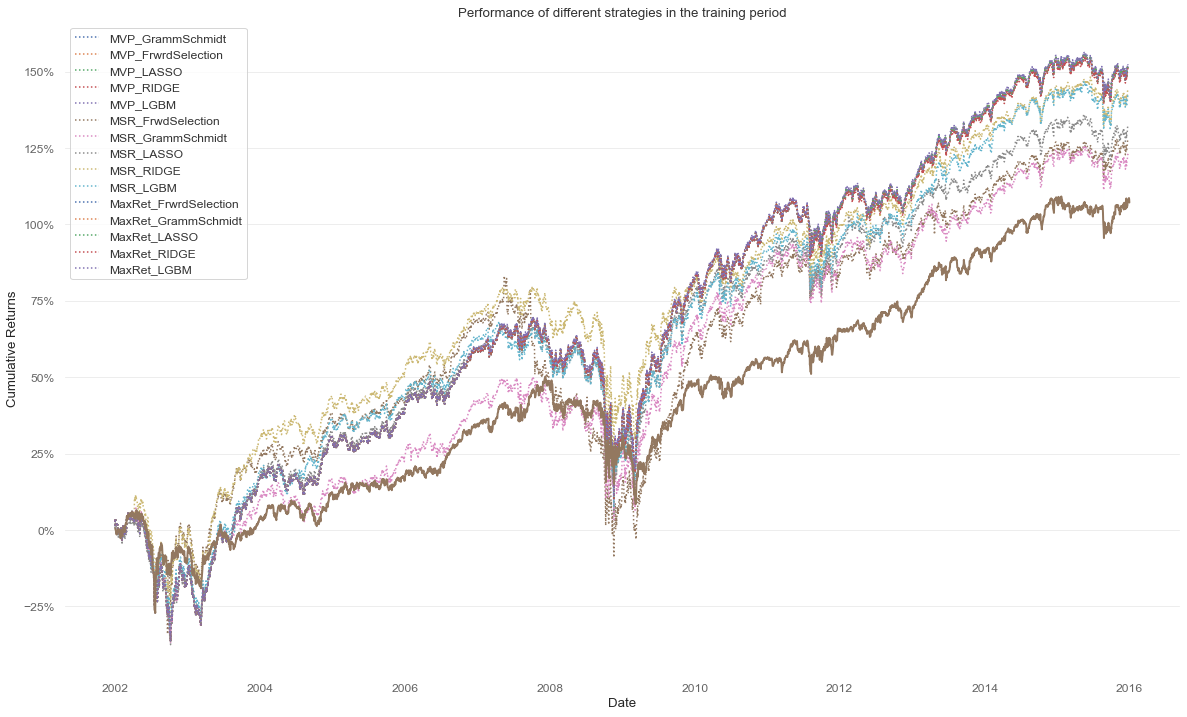

In [36]:
plt.figure(figsize=(20,12))
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.grid(axis="x")
plt.title("Performance of different strategies in the training period")
plt.plot(res_train.dropna().cumsum(), linestyle = 'dotted')
plt.plot((df_bm[(df_bm.index >= "2002-01-01") & (df_bm.index < "2016-01-01")]["ret_bm"]-1).cumsum(), linewidth = 2)
# x = list(res_test.columns)
# x+=(["Benchmark"])

plt.legend(res_train)
plt.savefig("Training_all.png", format="png", dpi=600, transparent=True)
plt.show()

,Total Returns,Sharpe Ratio
MVP_GrammSchmidt,1.514327,0.565117
MVP_FrwrdSelection,1.514327,0.565117
MVP_LASSO,1.514327,0.565117
MVP_RIDGE,1.514327,0.565117
MVP_LGBM,1.514327,0.565117
MSR_FrwdSelection,1.272559,0.443814
MSR_GrammSchmidt,1.225204,0.471085
MSR_LASSO,1.316253,0.492503
MSR_RIDGE,1.435235,0.533121
MSR_LGBM,1.416679,0.528874


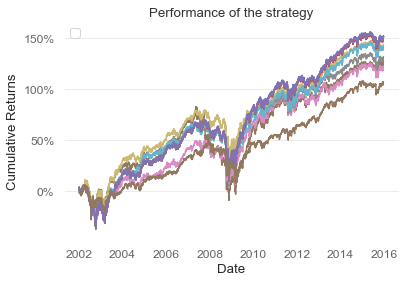

In [37]:
return_stats(res_train).to_csv("return_stats_train.csv", mode = "w")
plot_returns(res_train)
return_stats(res_train)

#### 3. Testing Period

In [38]:
training_results = res_train.mean()/res_train.std()*np.sqrt(252)
best_strategy = {training_results.idxmax() : configurations[training_results.idxmax()]}

# Remember that the beginning data will be missing in the results as it will be used for the rolling window
bk_test = Backtester(df=df[df.date >='2014-01-01'],
                rolling_frw = '1W',
                look_back_prm = 2*365,
                n_stocks = 50,
                level_winsorize = 0.01, # changing parameter to 0.01 for testing purposes.
                configurations = best_strategy,
                print_results=False)
res_test = bk_test.run_backtest_parallel()
clear_output()

In [39]:
# res_test.to_hdf("Test_1W.h5", key= "df", mode = "w")

In [40]:
res_test.head()

,MaxRet_LGBM
2016-01-04,0.000727
2016-01-05,-0.012539
2016-01-06,-0.021161
2016-01-07,-0.010922
2016-01-08,-0.000140


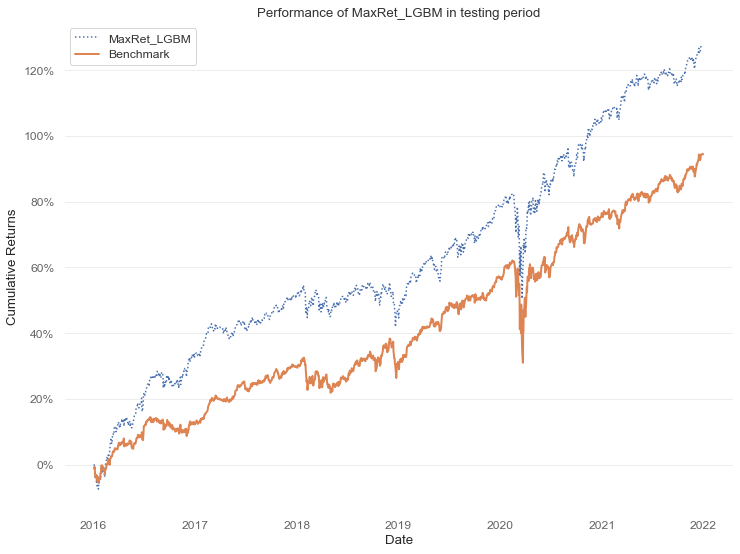

In [41]:
import matplotlib.ticker as mtick
plt.figure(figsize=(12,9))
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
plt.grid(axis="x")
plt.title("Performance of {} in testing period".format(training_results.idxmax()))
plt.plot(res_test.dropna().cumsum(), linestyle = 'dotted')
plt.plot((df_bm[(df_bm.index >= "2016-01-01")]["ret_bm"]-1).cumsum(), linewidth = 2)
x = list(res_test.columns)
x+=(["Benchmark"])

plt.legend(x)
# plt.savefig("training.png", format="png", dpi=600, transparent=True)
plt.show()

In [42]:
res_test.head()

,MaxRet_LGBM
2016-01-04,0.000727
2016-01-05,-0.012539
2016-01-06,-0.021161
2016-01-07,-0.010922
2016-01-08,-0.000140


,Total Returns,Sharpe Ratio
MaxRet_LGBM,1.278285,1.245389
Benchmark,0.942428,0.998918


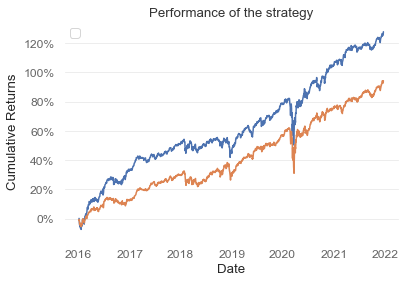

In [43]:
return_stats(res_test).to_csv("return_stats_train.csv", mode = "w")
plot_returns(res_test)
return_stats(res_test)

Analysis of the result for configuration: MSR_GrammSchmidt
Sharpe ratio = 1.1561537027946105
Annual return = 1.2226679953360762
Average daily return (bps)= 8.118645387357743


                           Strategy
-------------------------  ----------
Start Period               2016-01-04
End Period                 2021-12-23
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          209.16%
CAGR﹪                     20.8%

Sharpe                     1.16
Prob. Sharpe Ratio         99.74%
Smart Sharpe               0.98
Sortino                    1.68
Smart Sortino              1.43
Sortino/√2                 1.18
Smart Sortino/√2           1.01
Omega                      1.26

Max Drawdown               -29.08%
Longest DD Days            195
Volatility (ann.)          17.7%
Calmar                     0.72
Skew                       -0.01
Kurtosis                   18.05

Expected Daily %           0.07%
Expected Monthly %         1.58%
Expected Yearly %          20.7%
Kelly Criterion            11.88%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.75%
Expected Shortfall (cVaR)  -1.75%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-19,2020-03-20,2020-09-01,195,-29.079058,-23.502024
2,2018-09-21,2018-12-21,2019-02-15,147,-13.003915,-10.079964
3,2018-01-26,2018-02-07,2018-08-03,189,-9.100846,-8.437923
4,2020-09-02,2020-09-22,2020-10-09,37,-8.692580,-7.877717
5,2016-01-05,2016-01-19,2016-02-16,42,-7.330032,-6.455416


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


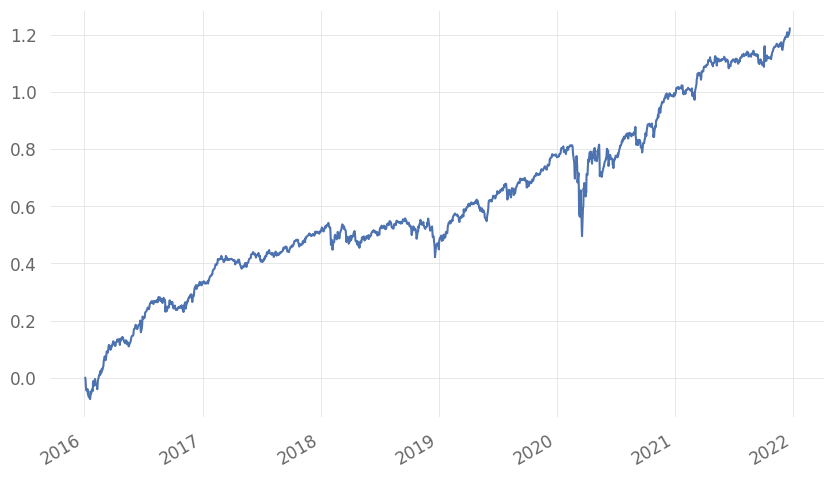

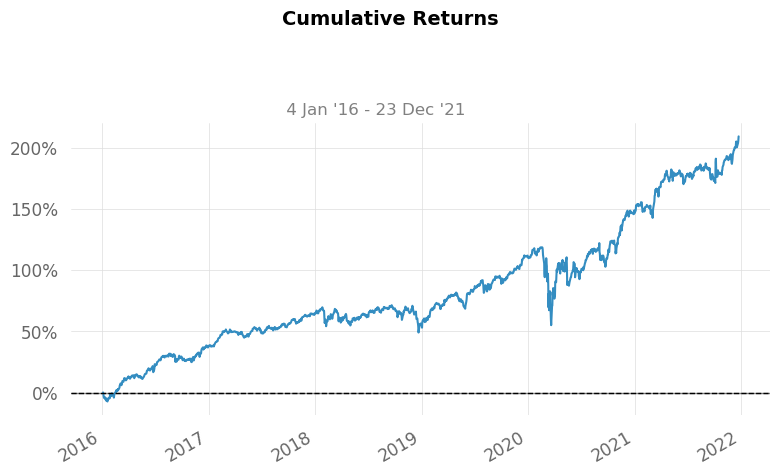

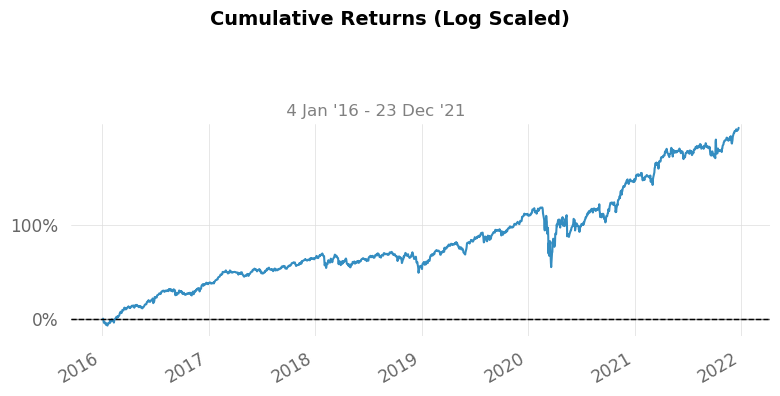

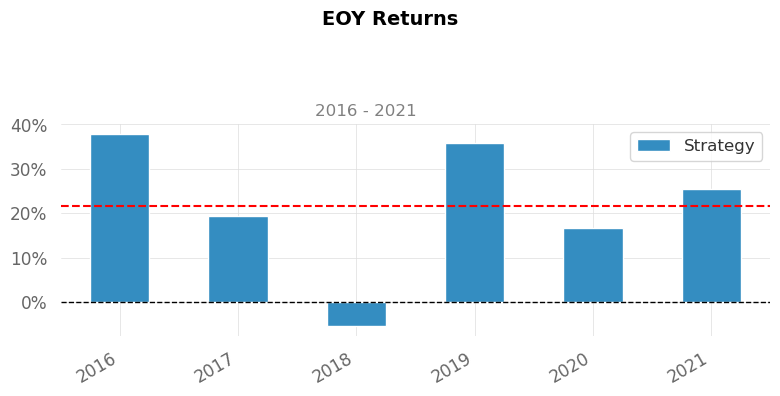

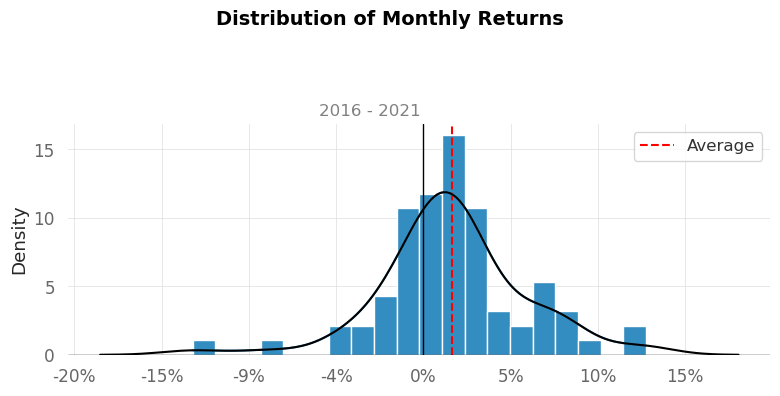

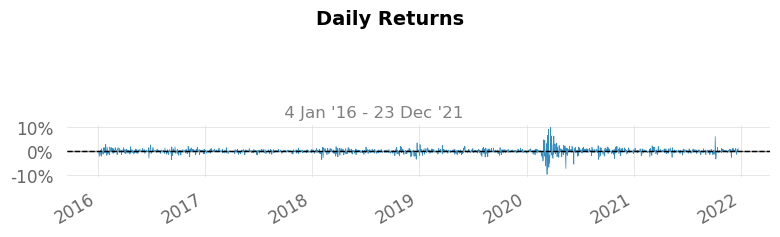

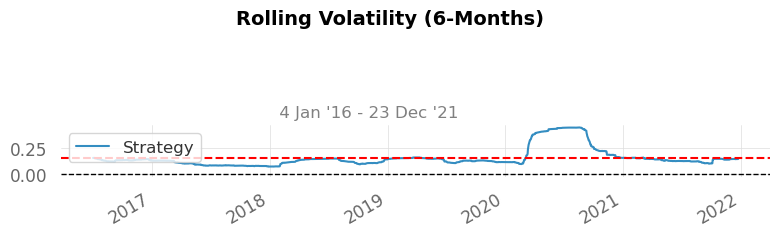

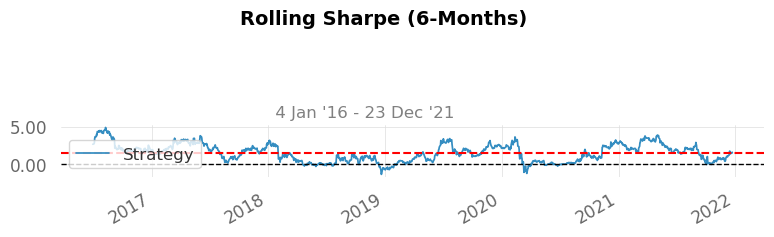

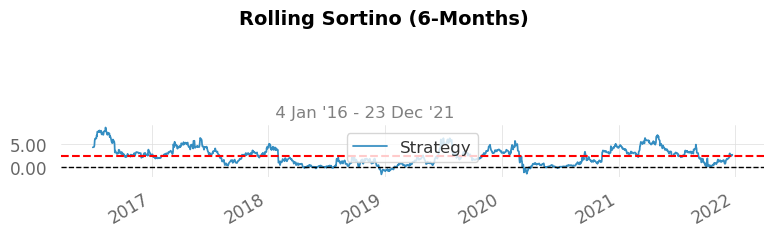

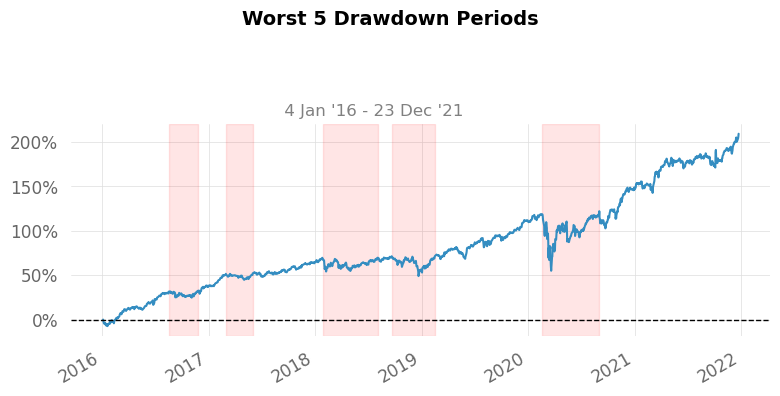

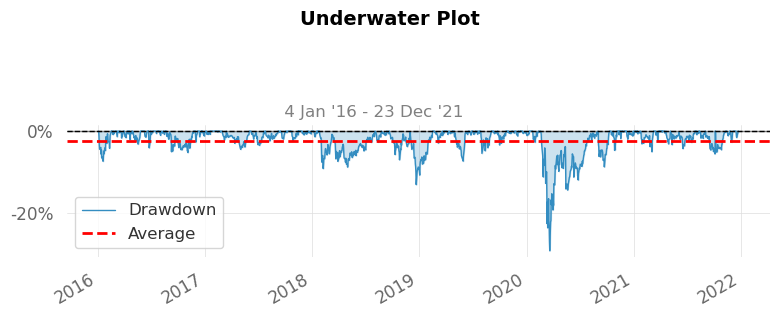

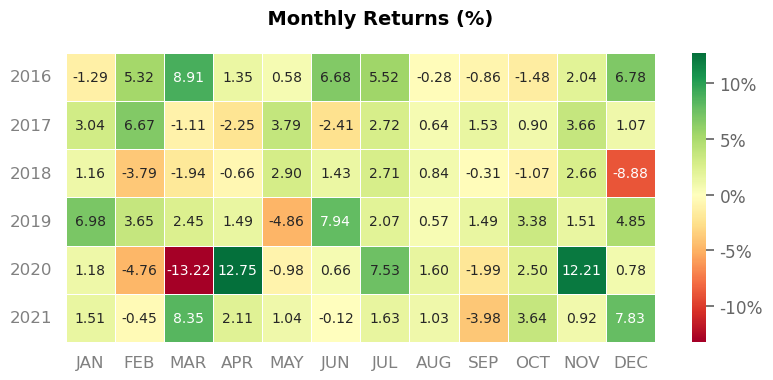

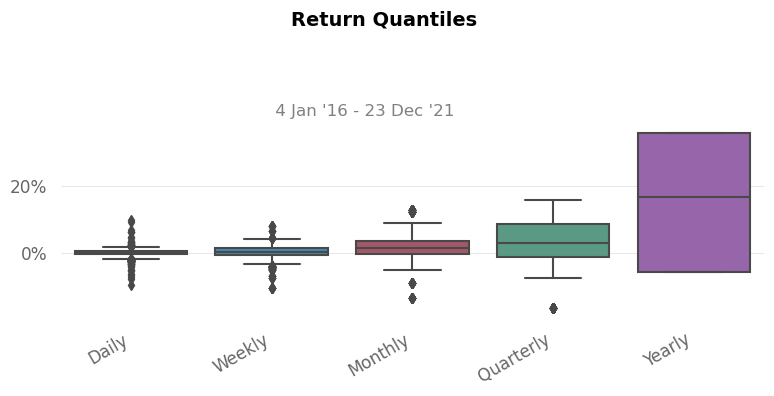

****************************************
Analysis of the result for configuration: Benchmark
Sharpe ratio = 0.9989183865038165
Annual return = 0.9424280354300162
Average daily return (bps)= 6.257822280411794


                           Strategy
-------------------------  ----------
Start Period               2016-01-04
End Period                 2021-12-23
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          138.16%
CAGR﹪                     15.64%

Sharpe                     1.0
Prob. Sharpe Ratio         99.24%
Smart Sharpe               0.8
Sortino                    1.44
Smart Sortino              1.16
Sortino/√2                 1.02
Smart Sortino/√2           0.82
Omega                      1.24

Max Drawdown               -28.62%
Longest DD Days            227
Volatility (ann.)          15.79%
Calmar                     0.55
Skew                       0.15
Kurtosis                   22.81

Expected Daily %           0.06%
Expected Monthly %         1.21%
Expected Yearly %          15.56%
Kelly Criterion            10.8%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.57%
Expected Shortfall (cVaR)  -1.57%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-18,2020-03-23,2020-07-27,160,-28.615675,-22.182853
2,2018-12-03,2018-12-24,2019-03-01,88,-11.448528,-9.141179
3,2018-01-29,2018-05-02,2018-09-13,227,-10.445332,-10.102410
4,2020-09-03,2020-09-23,2020-10-12,39,-5.983258,-5.384041
5,2018-09-24,2018-10-11,2018-11-06,43,-5.835084,-5.209067


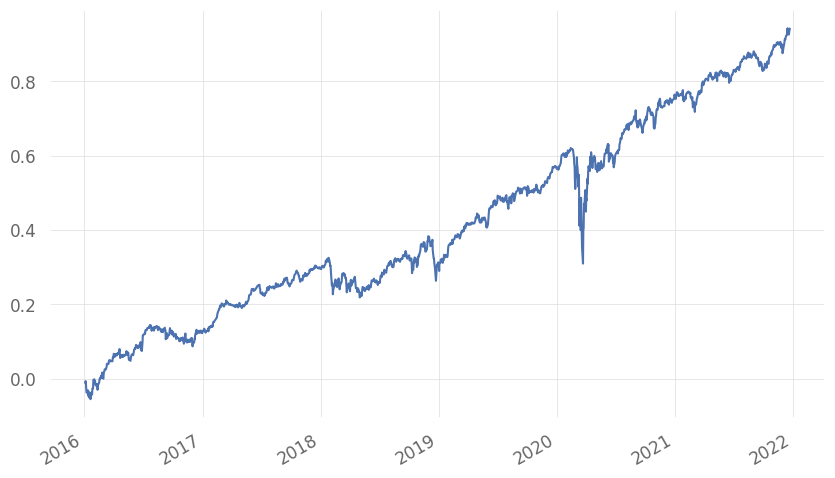

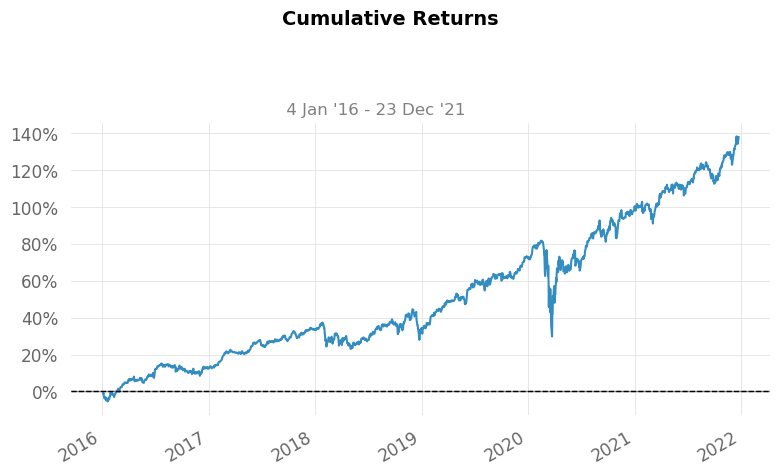

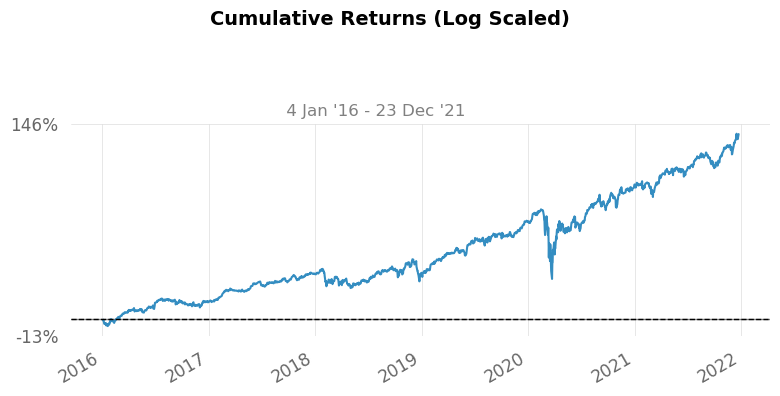

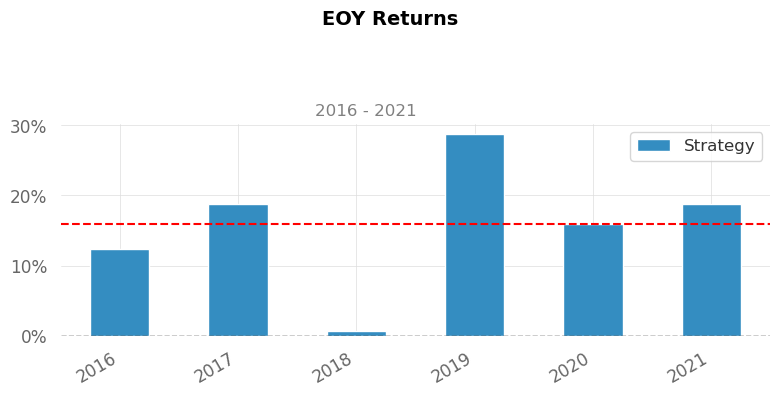

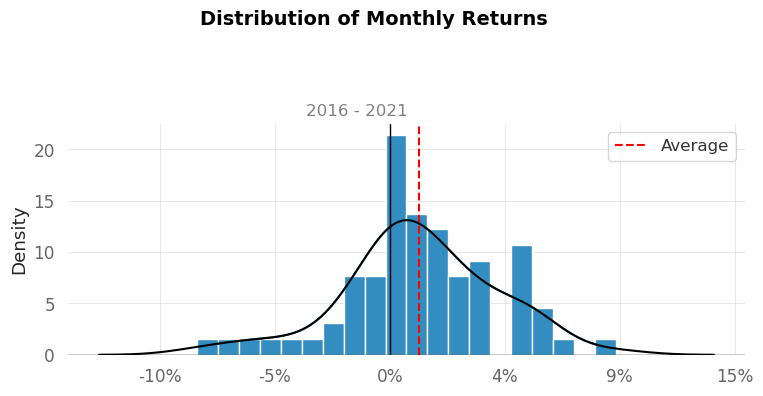

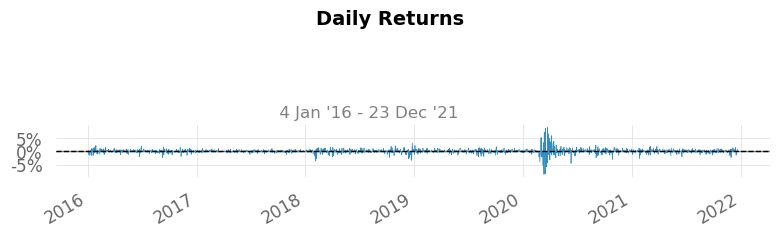

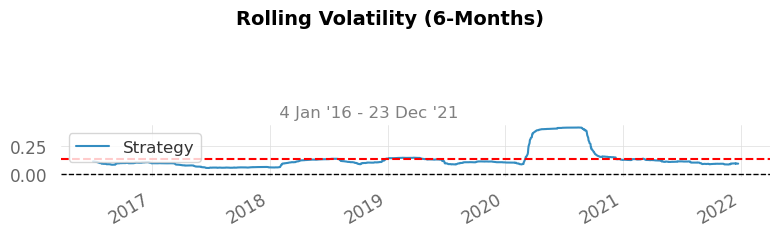

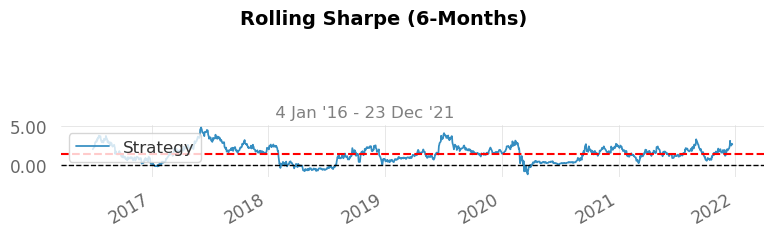

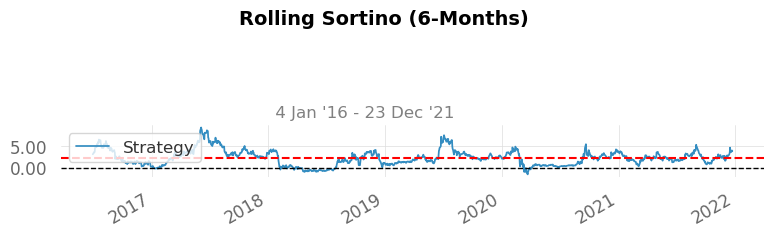

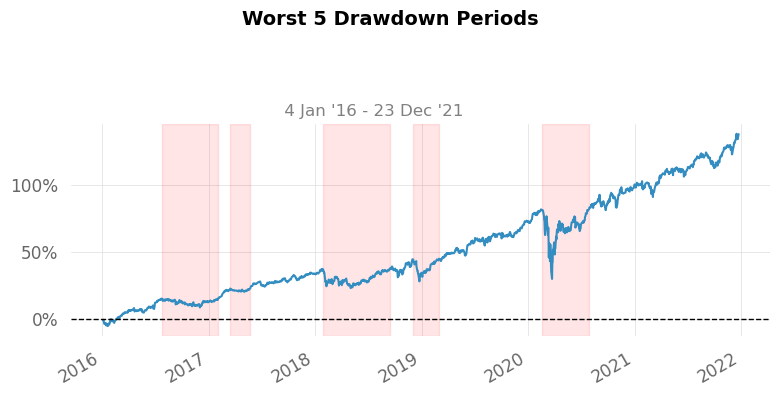

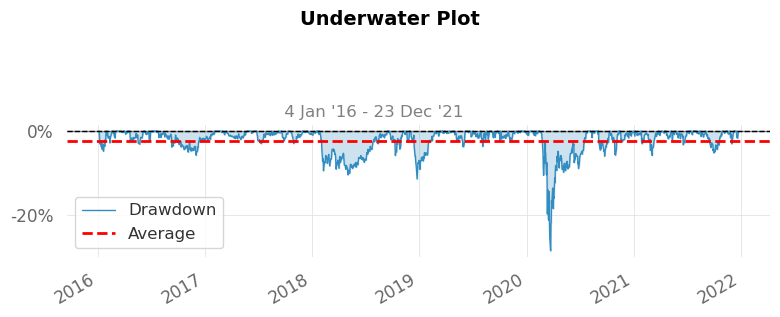

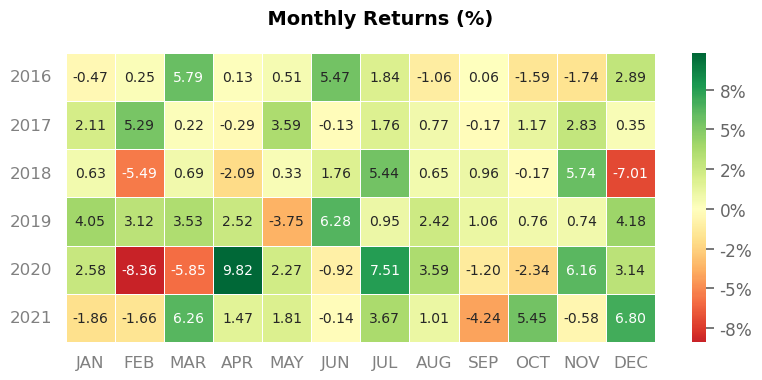

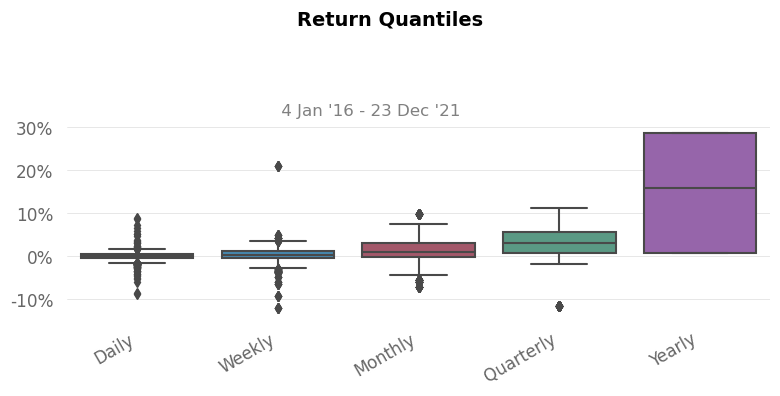

****************************************


In [58]:
print_results(res_test)